# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded .zip files
- Perform exploratory data analysis (EDA)
- Establish a baseline model
- Move from a simple model to an ensemble model
- Perform hyperparameter optimization
- Check feature importance


## Introduction to business scenario

You work for a travel booking website that wants to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed because of weather when they book a flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by using machine learning (ML) to identify whether the flight will be delayed because of weather. You have been given access to the a dataset about the on-time performance of domestic flights that were operated by large air carriers. You can use this data to train an ML model to predict if the flight is going to be delayed for the busiest airports.


## About this dataset

This dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018.


### Features

For more information about features in the dataset, see [On-time delay dataset features](https://www.transtats.bts.gov/Fields.asp).

### Dataset attributions  
Website: https://www.transtats.bts.gov/

Dataset(s) used in this lab were compiled by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available at https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=Mode_ID=1&Mode_Desc=Aviation&Subject_ID2=0.

# Step 1: Problem formulation and data collection

## Business problem, type of ML, and success metrics:

- Business Problem: How can we predict the delay status of an airplane delayed based on the state of the weather, the airline, the airplane origin, and the airplane destination?
- ML type: Binary Classification
- Success Metrics: F1-Score or Accuracy if target variable (plane delayed or not delayed) has an even class distribution, F1-Score otherwise.

## Analyze the appropriateness of the data 

The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018. Given the millions of domestic flights that occur each year in the US, this dataset which spans from 2013 to 2018 offers a very large number of data values for training, testing, and validating a Machine Learning model. More specifically, since this data contains the delay status for every single airline flight going from origin to destination every day from 2013 until 2018, this is a perfect dataset for a Binary Classification model (Supervised Learning) that predicts delay status based on date, time (time of day), origin, destination, and airline.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance with 25 GB storage using Amazon SageMaker AI (SDK Version - 2.248.2)

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, explore and visualize data to better understand it. First, import the necessary libraries and read the data into a pandas DataFrame. After importing the data, execute Exploratory Dat Analysis (EDA) on the dataset:  
- shape of the dataset
- cleanliness/completeness of columns
- datatype of columns (numerical, categorical)
- descriptive basic statistics on features (e.g., feature means and ranges)
- examine target column closely - e.g., determine its distribution.

## IMPORTS

## **{RE-RUN For Picking Up From a Bookmark} Library/Module IMPORT Cell**

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type='ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import IFrame

from tqdm import tqdm
tqdm.pandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib is building the font cache; this may take a moment.


## Pull datasets in from a public AWS S3 bucket

Start by bringing in the dataset from a public Amazon Simple Storage Service (Amazon S3) bucket to this notebook environment.

In [ ]:
!pwd

In [ ]:
!ls '/home/ec2-user/SageMaker/'

## **{RE-RUN For Picking Up From a Bookmark} Filepath Creation Cell**

In [2]:
# download the files

zip_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'

!mkdir -p {zip_path}
!mkdir -p {csv_base_path}

In [ ]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/ {zip_path} --recursive

In [ ]:
!ls '/home/ec2-user'

In [ ]:
!ls '/home/ec2-user/SageMaker/'

In [ ]:
!ls '/home/ec2-user/SageMaker/project/'

In [ ]:
!ls '/home/ec2-user/SageMaker/project/data/'

In [ ]:
!ls {zip_path}

In [ ]:
!ls -l {zip_path}

In [ ]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

print(type(zip_files))
for file_path_string in zip_files:
    print(file_path_string)

Extract comma-separated values (CSV) files from the .zip files.

In [ ]:
%%time

def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

In [ ]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

In [ ]:
# all_files = [str(file) for file in list(Path(csv_base_path).iterdir())]
# len(all_files)

In [ ]:
for file_path_string in csv_files:
    print(file_path_string)

Before you load the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information about the features that are included in the dataset.

In [ ]:
print(csv_base_path)

In [ ]:
!ls {csv_base_path}

## Data Dictionary and Background Information

In [ ]:
## Read the readme.html inside of the Jupyter Notebook

from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV file

Before you combine all the CSV files, examine the data from a single CSV file. By using pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the built-in `read_csv` function in Python ([pandas.read_csv documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [ ]:
df_temp = pd.read_csv(f"{csv_base_path}On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

## Alternative way to examine single CSV file example
# csv_example = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv'
# df_temp = pd.read_csv(csv_example)

In [ ]:
df_shape = df_temp.shape
print(f'Rows and columns in one CSV file is {df_shape}')

In [ ]:
# 
df_temp.head(5)

**Question**: Print all the columns in the dataset. To view the column names, use `<DataFrame>.columns`.

In [ ]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:  
    print(col)

Print all the columns in the dataset that contain the word *Del*.

In [ ]:
[x for x in df_temp.columns if 'Del' in x]  ## 

##### EDA of dataset

Explore the following:
1. Number of rows and columns in the dataset   
2. The Number of years included in the dataset
3. The date range for this dataset   
4. The airlines that are included   
5. The origin and destination airports covered

In [ ]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
# print("The #rows and #columns are ", df_shape[0] , " and ", df_shape[1])
print("The years in this dataset are: ", list(df_temp['Year'].unique()))
print("The months covered in this dataset are: ", list(df_temp['Month'].unique()))
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))

# print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
list_of_unique_airlines_09_18 = list(df_temp['Reporting_Airline'].unique())
print("The airlines covered in this dataset are: ", list_of_unique_airlines_09_18)
##Count the Number of Airlines in this dataset (i.e., Sept. 2018)
print("The number of unique airlines in dataset (09_18): ", len(list_of_unique_airlines_09_18))


# print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
list_of_origin_airports_09_18 = list(df_temp['Origin'].unique())
print("The Origin airports covered are: ", list_of_origin_airports_09_18)

# print(len(list(df_temp['Origin'].unique())))
# print(len(list(df_temp['Dest'].unique())))

# print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))
list_of_dest_airports_09_18 = list(df_temp['Dest'].unique())
print("The Destination airports covered are: ", list_of_dest_airports_09_18)
print("The Desitination airports covered are: ", len(list_of_dest_airports_09_18))

Count of all the origin and destination airports

In [ ]:
origin_series = df_temp['Origin']
dest_series = df_temp['Dest']

counts_dict = {'Origin_count': origin_series.value_counts(),
               'Dest_count': dest_series.value_counts()}
#print(counts_dict)
# print(counts_dict['Origin'])
# print(counts_dict['Dest'])

counts_df = pd.DataFrame(counts_dict)
display(counts_df)
print(counts_df['Origin_count'].loc['ABQ'])
print(counts_df['Origin_count'].loc[['ABQ', 'ABR']])

The top 15 origin and destination airports based on number of flights in the dataset.

In [ ]:
counts_df.sort_values(by='Origin_count',ascending=False).head(15) # 

In [ ]:
# counts.sort_values(by='Dest', ascending=False).head(3) # 

counts_df.sort_values(by='Dest_count', ascending=False).head(15) # 

#####  Notes on NASDelay

_NAS Delay. Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET._

##### Notes on CRSDepTime
_Computer Reservation System (CRS) Departure Time._

**Given all the information about a flight trip, can you predict if it would be delayed?**

The **ArrDel15** column is an indicator variable that takes the value *1* when the delay is more than 15 minutes. Otherwise, it takes a value of *0*.

You could use this as a target column for the classification problem.

Now, assume that you are traveling from San Francisco to Los Angeles on a work trip. You want to better manage your reservations in Los Angeles. Thus, want to have an idea of whether your flight will be delayed, given a set of features. How many features from this dataset would you need to know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or the destination. If there were a sudden weather delay 10 minutes before landing, this data wouldn't be helpful to managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top five airlines: UA, OO, WN, AA, DL

This information should help reduce the size of data across the CSV files that will be combined.

#### Combine all CSV files
 
First, create an empy DataFrame that you will use to copy your individual DataFrames from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe 
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the `subset_vals` in each of the `subset_cols`. To check if the `val` is in the DataFrame column, use the `isin` function in pandas ([pandas.DataFram.isin documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)). Then, choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the DataFrame with the empty DataFrame 

In [ ]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):

    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    file_name: The filepath for the .csv file that is created from the 'combine_csv' function
    """

    df = pd.DataFrame()
    
    for file in csv_files:
        print('csv file: ', file)
        df_temp = pd.read_csv(file)
        print('df shape for this csv as a pandas dataframe:', df_temp.shape)
        df_temp = df_temp[filter_cols]
        print(f'df shape after sub-selecting on {filter_cols} columns:', df_temp.shape)
        for col, val in zip(subset_cols, subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]
            print(f'df shape after filtering on {val} within {col}:', df_temp.shape)
        
        df = pd.concat([df, df_temp], axis=0)
      
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [ ]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

In [ ]:
###Example to show how the zip function works
zip_ex = zip(subset_cols, subset_vals)
zip_ex_list = list(zip_ex)
for item in zip_ex_list:
    print(item)

Use the previous function to merge all the different files into a single file that you can read easily. (5-7 minutes to complete)

In [ ]:
combined_csv_filename = f"{base_path}combined_files.csv"
print(combined_csv_filename)

In [ ]:
!ls -l /home/ec2-user/SageMaker/project/data/FlightDelays/

In [ ]:
start = time.time()

combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)

print(f'CSVs merged in {round((time.time() - start)/60,2)} minutes')

#### Load the dataset

Load the combined dataset.

## BOOKMARK -- Pick Up Here if 'combined_files.csv' is retained within the '/home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv' filepath

In [70]:
combined_csv_filename = f"{base_path}combined_files.csv"
print(combined_csv_filename)

! ls -l {combined_csv_filename}

/home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv
-rw-rw-r-- 1 ec2-user ec2-user 136023260 Jul 22 16:46 /home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv


In [71]:
##BOOKMARK -- Pick Up Here if 'combined_files.csv' is retained within the '/home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv' filepath

data = pd.read_csv(combined_csv_filename)
print(data.shape)

(1658130, 20)


### Cells to re-run if this 'combined_files.csv' is retained and reused for the rest of this Notebook:

- "**Library/Module IMPORT Cell**"
- "**Filepath Creation Cell**"

Print the first five records.

In [72]:
print(data.shape)
data.head(5)

(1658130, 20)


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2017        2      4           1          6  2017-04-01                DL   
1  2017        2      4           1          6  2017-04-01                DL   
2  2017        2      4           1          6  2017-04-01                DL   
3  2017        2      4           1          6  2017-04-01                DL   
4  2017        2      4           1          6  2017-04-01                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  DFW        TX        1920        0.0       0.0   
1    DFW          TX  ATL        GA        1717        0.0       0.0   
2    SFO          CA  ATL        GA        1405        0.0       0.0   
3    SFO          CA  ATL        GA         600        0.0       0.0   
4    ATL          GA  SFO        CA        1640        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     731.0              3     -25.0              0.0       0.0    106.0  
1     731.0              3     -16.0              0.0       0.0     97.0  
2    2139.0              9      31.0             31.0       1.0    255.0  
3    2139.0              9      15.0             15.0       1.0    257.0  
4    2139.0              9      58.0             58.0       1.0    262.0

##### EDA of transformed dataset

Explore the following:
1. Number of rows and columns in the dataset   
2. The Number of years included in the dataset
3. The date range for this dataset   
4. The airlines that are included   
5. The origin and destination airports covered

In [73]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", list(data['Month'].unique()))
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2017, 2015, 2018, 2016, 2014]
The months covered in this dataset are:  [4, 6, 9, 2, 10, 12, 5, 1, 11, 3, 7, 8]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'WN', 'UA', 'AA', 'OO']
The Origin airports covered are:  ['ATL', 'DFW', 'SFO', 'IAH', 'LAX', 'PHX', 'ORD', 'DEN', 'CLT']
The Destination airports covered are:  ['DFW', 'ATL', 'SFO', 'LAX', 'ORD', 'IAH', 'CLT', 'DEN', 'PHX']


Define your target column: **is_delay** (*1* means that the arrival time delayed more than 15 minutes, and *0* means all other cases). To rename the column from **ArrDel15** to *is_delay*, use the `rename` method .

In [74]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) # 

Look for nulls across columns. You can use the `isnull()` function

In [75]:
data.isnull()

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate  \
0        False    False  False       False      False       False   
1        False    False  False       False      False       False   
2        False    False  False       False      False       False   
3        False    False  False       False      False       False   
4        False    False  False       False      False       False   
...        ...      ...    ...         ...        ...         ...   
1658125  False    False  False       False      False       False   
1658126  False    False  False       False      False       False   
1658127  False    False  False       False      False       False   
1658128  False    False  False       False      False       False   
1658129  False    False  False       False      False       False   

         Reporting_Airline  Origin  OriginState   Dest  DestState  CRSDepTime  \
0                    False   False        False  False      False       False   
1                    False   False        False  False      False       False   
2                    False   False        False  False      False       False   
3                    False   False        False  False      False       False   
4                    False   False        False  False      False       False   
...                    ...     ...          ...    ...        ...         ...   
1658125              False   False        False  False      False       False   
1658126              False   False        False  False      False       False   
1658127              False   False        False  False      False       False   
1658128              False   False        False  False      False       False   
1658129              False   False        False  False      False       False   

         Cancelled  Diverted  Distance  DistanceGroup  ArrDelay  \
0            False     False     False          False     False   
1            False     False     False          False     False   
2            False     False     False          False     False   
3            False     False     False          False     False   
4            False     False     False          False     False   
...            ...       ...       ...            ...       ...   
1658125      False     False     False          False     False   
1658126      False     False     False          False     False   
1658127      False     False     False          False     False   
1658128      False     False     False          False     False   
1658129      False     False     False          False     False   

         ArrDelayMinutes  is_delay  AirTime  
0                  False     False    False  
1                  False     False    False  
2                  False     False    False  
3                  False     False    False  
4                  False     False    False  
...                  ...       ...      ...  
1658125            False     False    False  
1658126            False     False    False  
1658127            False     False    False  
1658128            False     False    False  
1658129            False     False    False  

[1658130 rows x 20 columns]

The arrival delay details and airtime are missing for 22,540 out of 1,658,130 rows, which is 1.3 percent. You can either remove or impute these rows. The documentation doesn't mention any information about missing rows.


In [76]:
data.isnull().sum(axis = 0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

In [77]:
### Remove null rows with null values
data_2 = data[~data.is_delay.isnull()]
data_2.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

In [78]:
data = data_2
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", list(data['Month'].unique()))
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))

The #rows and #columns are  1635590  and  20
The years in this dataset are:  [2017, 2015, 2018, 2016, 2014]
The months covered in this dataset are:  [4, 6, 9, 2, 10, 12, 5, 1, 11, 3, 7, 8]
The date range for data is : 2014-01-01  to  2018-12-31


Get the hour of the day in 24-hour-time format from CRSDepTime.

In [ ]:
data_3 = data_2.copy()
data_3['DepHourofDay'] = (data_2['CRSDepTime']//100) ## // is Floor Division

In [80]:
data_3[['DepHourofDay', 'CRSDepTime']]

DepHourofDay  CRSDepTime
0                  19        1920
1                  17        1717
2                  14        1405
3                   6         600
4                  16        1640
...               ...         ...
1658125             7         708
1658126            15        1525
1658127            17        1735
1658128            18        1825
1658129             9         946

[1635590 rows x 2 columns]

In [81]:
data = data_3
print(data.columns)
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')
The #rows and #columns are  1635590  and  21


## The ML problem statement
- Given a set of features, predict if a flight is going to be delayed more than 15 minutes

Look at feature distribution, correlations, and others.
- Assess non-linearity or patterns in the data
    - Linear models: Add power, exponential, or interaction features
    - Try a non-linear model
- Data imbalance 
    - Choose metrics that won't give biased model performance (accuracy versus the area under the curve, or AUC)
    - Use weighted or custom loss functions
- Missing data
    - Do imputation based on simple statistics -- mean, median, mode (numerical variables), frequent class (categorical variables)
    - Clustering-based imputation (k-nearest neighbors, or KNNs, to predict column value)
    - Drop column

### Data exploration

Check the class *is_delay* versus *no delay*.


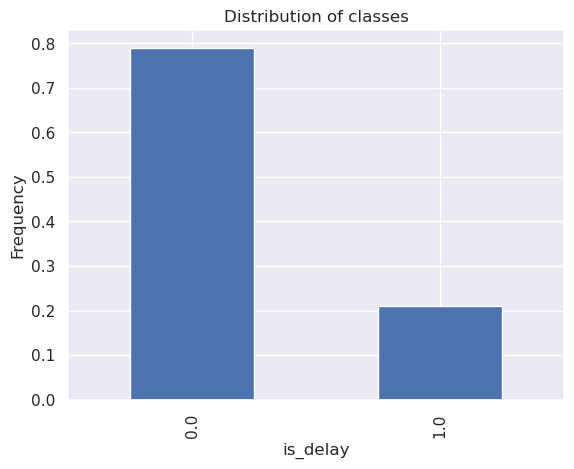

In [82]:
(data_3.groupby('is_delay').size()/len(data) ).plot(kind='bar')# 
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of *delay* versus *no delay*?

Run the following two cells and answer the questions.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

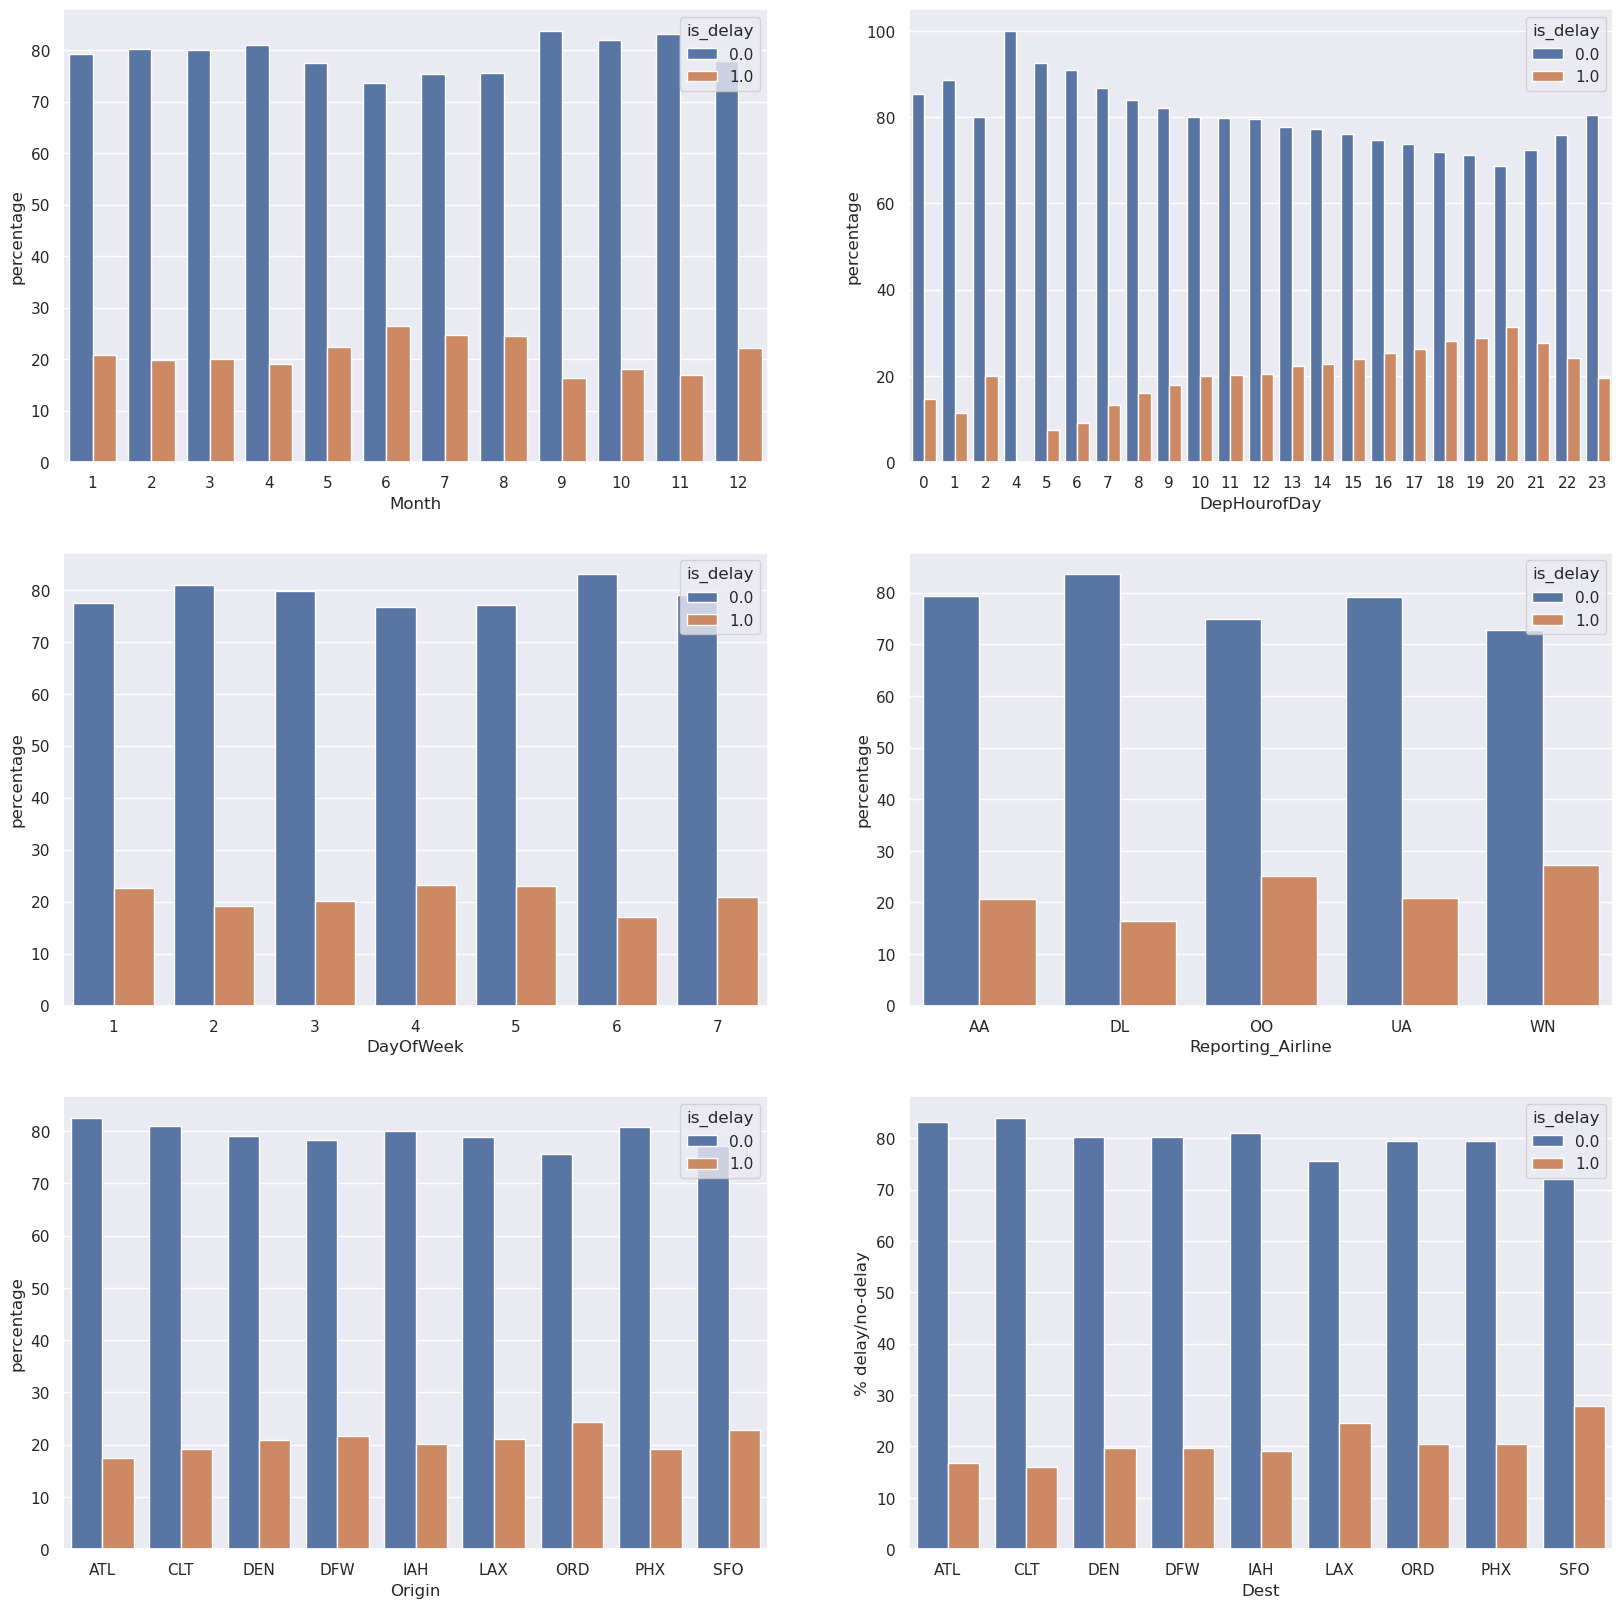

In [84]:
data = data_3

viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

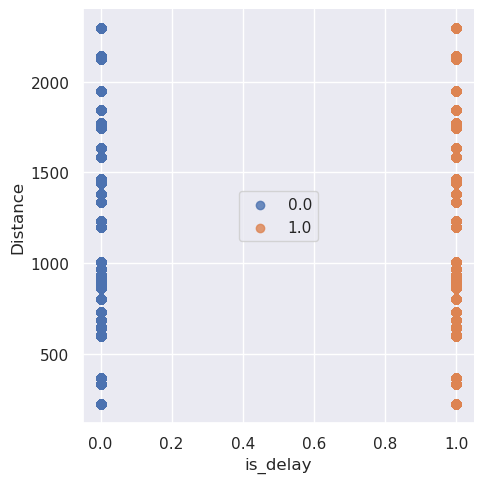

In [85]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**Questions  to Answer**

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

### Features

Look at all the columns and what their specific types are.

In [87]:
data_3.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [88]:
data_3.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- *Date* is redundant, because you have *Year*, *Quarter*, *Month*, *DayofMonth*, and *DayOfWeek* to describe the date.
- Use *Origin* and *Dest* codes instead of *OriginState* and *DestState*.
- Because you are only classifying whether the flight is delayed or not, you don't need *TotalDelayMinutes*, *DepDelayMinutes*, and *ArrDelayMinutes*.

Treat *DepHourofDay* as a categorical variable because it doesn't have any quantitative relation with the target.
- If you needed to do a one-hot encoding of this variable, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- In this case, you only need to split into buckets.

In [89]:
data_orig = data_3.copy()
data_4 = data_3[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data_4[c] = data_4[c].astype('category')

In [90]:
data_4.dtypes

is_delay              float64
Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
Distance              float64
DepHourofDay         category
dtype: object

### One-hot Encoding

In [91]:
data_dummies = pd.get_dummies(data_4[categorical_columns], drop_first=True) # 
print(len(data_dummies.columns))
data_dummies.columns

92


Index(['Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12',
       'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16',
       'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20',
       'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24',
       'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28',
       'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO',
       'Reporting_Airline_UA', 'Reporting_Airline_WN', 'Origin_CLT',
       'Origin_DEN', 'Origin_DFW', 'Origin_I

In [92]:
print('data_4.shape: ', data_4.shape)
print('data_4.columns.tolist(): ', data_4.columns.tolist())
print('data_dummies.shape: ', data_dummies.shape)

data_5 = pd.concat([data_4, data_dummies], axis = 1)
###data_5 = pd.concat([data_orig, data_dummies], axis = 1)
print('data_5.shape Before drop: ', data_5.shape)
data_5.drop(categorical_columns, axis=1, inplace=True)
print('data_5.shape After drop: ', data_5.shape)
print(data_5.columns)
print(data_5.columns.tolist())

data_4.shape:  (1635590, 10)
data_4.columns.tolist():  ['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']
data_dummies.shape:  (1635590, 92)
data_5.shape Before drop:  (1635590, 102)
data_5.shape After drop:  (1635590, 94)
Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMont

In [93]:
data_5_dtypes_series = data_5.dtypes
data_5_dtypes_list = data_5_dtypes_series.tolist()
data_5_col_name_list = data_5.columns.tolist()
zip_of_col_name_dtype = zip(data_5_col_name_list, data_5_dtypes_list)
print(data_5_col_name_list)
print()
print(list(zip_of_col_name_dtype))
print()

['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO', 'Dest_CLT', 

Check the length of the dataset and the new columns.

In [94]:
# 
print(len(data_dummies.columns))

92


In [95]:
data_dummies.dtypes

Quarter_2          bool
Quarter_3          bool
Quarter_4          bool
Month_2            bool
Month_3            bool
                   ... 
DepHourofDay_19    bool
DepHourofDay_20    bool
DepHourofDay_21    bool
DepHourofDay_22    bool
DepHourofDay_23    bool
Length: 92, dtype: object

Rename the **is_delay** column to *target*.

In [96]:
data_5.rename(columns = {'is_delay':'target'}, inplace=True )# 
print(len(data_dummies.columns))
print(data_dummies.columns)
print()
print(len(data_5.columns))
print(data_5.columns)

92
Index(['Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12',
       'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16',
       'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20',
       'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24',
       'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28',
       'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO',
       'Reporting_Airline_UA', 'Reporting_Airline_WN', 'Origin_CLT',
       'Origin_DEN', 'Origin_DFW', 'Origi

In [97]:
display(data_5.head(5))

target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     731.0       True      False      False    False    False   
1     0.0     731.0       True      False      False    False    False   
2     1.0    2139.0       True      False      False    False    False   
3     1.0    2139.0       True      False      False    False    False   
4     1.0    2139.0       True      False      False    False    False   

   Month_4  Month_5  Month_6  ...  DepHourofDay_14  DepHourofDay_15  \
0     True    False    False  ...            False            False   
1     True    False    False  ...            False            False   
2     True    False    False  ...             True            False   
3     True    False    False  ...            False            False   
4     True    False    False  ...            False            False   

   DepHourofDay_16  DepHourofDay_17  DepHourofDay_18  DepHourofDay_19  \
0            False            False            False             True   
1            False             True            False            False   
2            False            False            False            False   
3            False            False            False            False   
4             True            False            False            False   

   DepHourofDay_20  DepHourofDay_21  DepHourofDay_22  DepHourofDay_23  
0            False            False            False            False  
1            False            False            False            False  
2            False            False            False            False  
3            False            False            False            False  
4            False            False            False            False  

[5 rows x 94 columns]

## BOOKMARK 2 -- Write Culminating DataFrame from Step 2 as CSV to 'step_2_df_filepath' filepath

In [98]:
data_orig_df_filepath = f"{base_path}data_orig_df.csv"
print(data_orig_df_filepath)
step_2_df_filepath = f"{base_path}step_2_df.csv"
print(step_2_df_filepath)

/home/ec2-user/SageMaker/project/data/FlightDelays/data_orig_df.csv
/home/ec2-user/SageMaker/project/data/FlightDelays/step_2_df.csv


In [99]:
start = time.time()

data_5.to_csv(step_2_df_filepath, index=False) 
data_orig.to_csv(data_orig_df_filepath, index=False) 

print(f'Run time: {round((time.time() - start)/60,2)} minutes')

Run time: 0.86 minutes


In [100]:
! ls -l {step_2_df_filepath}

-rw-rw-r-- 1 ec2-user ec2-user 908531077 Jul 22 19:33 /home/ec2-user/SageMaker/project/data/FlightDelays/step_2_df.csv


In [101]:
! ls -l {data_orig_df_filepath}

-rw-rw-r-- 1 ec2-user ec2-user 138938414 Jul 22 19:33 /home/ec2-user/SageMaker/project/data/FlightDelays/data_orig_df.csv


## ** Load Pandas DataFrame from 'step_2_df_filepath' for completing Step 3 and from 'data_orig_df_filepath' for 'data_orig' df

In [6]:
data_orig_df_filepath = f"{base_path}data_orig_df.csv"
print(data_orig_df_filepath)
data_orig = pd.read_csv(data_orig_df_filepath)
print('data_orig.shape: ', data_orig.shape)
data_orig_first_16k = data_orig[:16000]
print('data_orig_first_16k.shape: ', data_orig_first_16k.shape)

step_2_df_filepath = f"{base_path}step_2_df.csv"
print(step_2_df_filepath)

data_all = pd.read_csv(step_2_df_filepath)
print('data_all.shape: ', data_all.shape)
data_first_16k = data_all[:16000]
print('data_first_16k.shape: ', data_first_16k.shape)
data = data_first_16k
###data = data_all

/home/ec2-user/SageMaker/project/data/FlightDelays/data_orig_df.csv
data_orig.shape:  (1635590, 21)
data_orig_first_16k.shape:  (16000, 21)
/home/ec2-user/SageMaker/project/data/FlightDelays/step_2_df.csv
data_all.shape:  (1635590, 94)
data_first_16k.shape:  (16000, 94)


In [9]:
###Function for checking which Columns are showing as having a string/object data type

def inspect_df(df):
    if isinstance(df, pd.DataFrame):
        df_dtypes_series = df.dtypes
        df_dtypes_list = df_dtypes_series.tolist()
        print("Is a Pandas DataFrame!")
        print('Shape =', df.shape)
        
        # Check if any column has 'object' (string) dtype
        has_string_columns = (df.dtypes == 'object').any()
        if has_string_columns:
            print("At least one column has a string data type.")
        else:
            print("No columns have a string data type.")
        
        print('All Column names: ')
        print(df.columns)
        print('Boolean Column names: ')
        bool_cols = df.select_dtypes(include='bool').columns
        print(bool_cols)
        print(df_dtypes_list)
        display(df.head(5))
    else:
        print('Not a Pandas DataFrame!')
        print('Data Structure is: ', type(df))

inspect_df(data)

<class 'pandas.core.series.Series'>
<class 'list'>
(16000, 94)
Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA

# Step 3: Model training and evaluation

You must include some preliminary steps when you convert the dataset from a DataFrame to a format that a machine learning algorithm can use. For Amazon SageMaker, you must perform these steps:

1. Split the data into `train_data`, `validation_data`, and `test_data` by using `sklearn.model_selection.train_test_split`.  

2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).  

3. Upload the data to your S3 bucket. If you haven't created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).  

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, write down the key decisions that you made in this phase.</span>

### 3-1. Train-Validate-Test Split

In [15]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [16]:
##Capture Column names of 'data' DataFrame as a List
list_of_col_names = data.columns
print('list_of_col_names: ', list_of_col_names)

train, validate, test = split_data(data)
print(type(train))
print(type(validate))
print(type(test))

train_target_series = train['target']
validate_target_series = validate['target']
test_target_series = test['target']

print(train_target_series.value_counts())
print(validate_target_series.value_counts())
print(test_target_series.value_counts())

print()
print(train_target_series.value_counts()/train_target_series.count())
print(validate_target_series.value_counts()/validate_target_series.count())
print(test_target_series.value_counts()/test_target_series.count())

list_of_col_names:  Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Origin_C

## Train Model with SageMaker SDK Version 2 (2.248.2)

In [22]:
import sagemaker

# Print the installed version of the sagemaker library
print(f"SageMaker SDK Version: {sagemaker.__version__}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
SageMaker SDK Version: 2.248.1


### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [23]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.8G     0  7.8G   0% /dev
tmpfs           7.9G     0  7.9G   0% /dev/shm
tmpfs           7.9G  668K  7.9G   1% /run
tmpfs           7.9G     0  7.9G   0% /sys/fs/cgroup
/dev/xvda1      135G   79G   57G  58% /
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1000
tmpfs           1.6G     0  1.6G   0% /run/user/0


In [24]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker


## 3-2. Convert DataFrame of train, validate, and test sets to Arrays with Non-string/object data types

In [26]:
start = time.time()

##Function for converting Dataframe to Array with all items having a float datatype
def df_to_float_array(df):
    df_to_array = df.values
    df_to_list_of_lists = df_to_array.tolist()
    #print(type(df))
    #print(type(df_to_array))
    #print(type(df_to_list_of_lists))
    df_to_list_of_arrays_float = []
    for sublist in df_to_list_of_lists:
        new_sublist = []
        sublist_array = np.array(sublist)
        sublist_array_float = sublist_array.astype(np.float32)
        df_to_list_of_arrays_float.append(sublist_array_float)
    df_to_array_float = np.array(df_to_list_of_arrays_float)
    print("\ntype(df_to_array_float): ", type(df_to_array_float))
    print("shape of df_to_array_float = ", df_to_array_float.shape)
    print("Data types of elements in df_to_array_float: ", df_to_array_float.dtype)
    #print()
    return df_to_array_float

##Function for converting DataFrame columns with String or Object datatype to a Boolean
def convert_object_cols_to_bool(df):
    #Select columns with 'object' (string) data type
    object_columns_df = df.select_dtypes(include=['object'])

    #Get a list of the column names
    object_column_names = object_columns_df.columns.tolist()

    print('\nList of column names with string or object data type:')
    print(object_column_names)

    #Convert cols with string/object type to boolean
    df[object_column_names] = df[object_column_names].astype(bool)

    print("\nDataFrame object dtypes after astype(bool):")
    print(df[object_column_names].dtypes)
    #print("\nDataFrame content after astype(bool):")
    #print(df[object_column_names].head(5))
    return df

train_no_objects = convert_object_cols_to_bool(train)
validate_no_objects = convert_object_cols_to_bool(validate)
test_no_objects = convert_object_cols_to_bool(test)

train_array_float = df_to_float_array(train_no_objects)
validate_array_float = df_to_float_array(validate_no_objects)
test_array_float = df_to_float_array(test_no_objects)

print(f'Run time: {round((time.time() - start)/60,2)} minutes')


List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (1308472, 94)
Data types of elements in df_to_array_float:  float32

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (163559, 94)
Data types of elements in df_to_array_float:  float32

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (163559, 94)
Data types of elements in df_to_array_float:  float32
Run time: 0.47 minutes


## 3-3. Imports for Building LinearLearner Model

In [27]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
# We no longer need TrainingInput for this workflow
from sagemaker import LinearLearner

from sklearn.model_selection import train_test_split
from sagemaker.analytics import TrainingJobAnalytics
import time
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup SageMaker Session and Role (Unchanged)
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/ll-records'

print(f"Using S3 bucket: {bucket}")
print(f"Using the following prefix: {prefix}")

Using S3 bucket: sagemaker-us-east-1-496057999101
Using the following prefix: sagemaker/ll-records


## 3-4. Create X and y for training, validation, and test sets

In [28]:
## Create X and y for training, validation, and test sets

X_train = train_array_float[:,1:]
y_train = train_array_float[:,0]
X_val = validate_array_float[:,1:]
y_val = validate_array_float[:,0]
X_test = test_array_float[:,1:]
y_test = test_array_float[:,0]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")
print(f"Test target shape: {y_test.shape}")

Training set shape: (1308472, 93)
Validation set shape: (163559, 93)
Test set shape: (163559, 93)
Training target shape: (1308472,)
Validation target shape: (163559,)
Test target shape: (163559,)


## 3-5. {OPTIONAL Cell to run} Ensure training, validation, and test set Arrays are of dtype of Float32

In [29]:
start = time.time()

print()

def assess_array_dtype(array):
    print('Data type of array: ', array.dtype)

def convert_array_to_float32(array):
    print('Initial Data type of array: ', array.dtype)
    array_float32 = array.astype(np.float32)
    print('Data type of Converted (to Float32) array: ', array_float32.dtype)
    return array_float32

def convert_array_to_int(array):
    print('Initial Data type of array: ', array.dtype)
    array_int = array.astype(int)
    array_int32 = array_int.astype(np.int32)
    print('Data type of Converted (to int) array: ', array_int.dtype)
    print('Data type of Converted (to int) array: ', array_int32.dtype)
    return array_int


### Ensure Training, Validation, and Test sets are all of data type Float32
train_array_float = convert_array_to_float32(train_array_float)
validate_array_float = convert_array_to_float32(validate_array_float)
test_array_float = convert_array_to_float32(test_array_float)

###For Converting Features and Labels to Float32
list_converted_array_names = [
    'X_train_float32', 'y_train_float32', 
    'X_val_float32', 'y_val_float32', 
    'X_test_float32', 'y_test_float32'
]

### Create Dictionary of all Cross Validation Feature and Target data sets
list_of_arrays_to_convert = [X_train, y_train, X_val, y_val, X_test, y_test]

zip_of_converted_arrays = zip(list_converted_array_names, list_of_arrays_to_convert)
print(type(zip_of_converted_arrays))
print(zip_of_converted_arrays)

dict_of_converted_arrays = {}

# ###For Converting Features and Labels to Float32
for index, val in enumerate(zip_of_converted_arrays):
    print(index)
    #print(val[0])
    #print(val[1])
    dict_of_converted_arrays[val[0]] = convert_array_to_float32(val[1])
    print('Array dtype: ', dict_of_converted_arrays[val[0]].dtype)
    print('Array Shape: ', dict_of_converted_arrays[val[0]].shape)
    
print()
print("Length of dict_of_converted_arrays = {}".format(len(dict_of_converted_arrays)))
print("type(dict_of_converted_arrays['X_train_float32']): ", type(dict_of_converted_arrays['X_train_float32']))
print("dict_of_converted_arrays['X_train_float32'].dtype: ", dict_of_converted_arrays['X_train_float32'].dtype)
print("dict_of_converted_arrays['X_train_float32'].shape: ", dict_of_converted_arrays['X_train_float32'].shape)
print()

print(f'Run time: {round((time.time() - start)/60,2)} minutes')


Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
<class 'zip'>
0
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Array dtype:  float32
Array Shape:  (1308472, 93)
1
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Array dtype:  float32
Array Shape:  (1308472,)
2
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Array dtype:  float32
Array Shape:  (163559, 93)
3
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Array dtype:  float32
Array Shape:  (163559,)
4
Initial Data type of array:  float32
Data type of Converted (to Float32) array:  float32
Array dtype:  float32
Array Shape:  (163559, 93)
5
Initial Data type of

## 3-6. Create LinearLearner Estimator

In [30]:
start = time.time()

###Create the LinearLearner Estimator (Unchanged)
ll_estimator = LinearLearner(
    role=role,
    instance_count=1,
    #instance_type='ml.m5.large',
    instance_type='ml.m4.xlarge',
    predictor_type='binary_classifier',
    feature_dim=2,
    mini_batch_size=100,
    binary_classifier_model_selection_criteria = 'cross_entropy_loss',
    # Add this line to enable metric calculation
    #eval_metrics=['accuracy', 'binary_f1', 'precision', 'recall'],
    #eval_metrics=['validation:precision', 'recall'],
    eval_metrics=['validation:precision', 'validation:recall', 'validation:f1', 'validation:accuracy'],
    sagemaker_session=sagemaker_session
)


###Create RecordSet objects üí°
# Add this check before your ll_estimator.record_set() calls
print(f"Training data shapes:   Features={X_train.shape}, Labels={y_train.shape}")
print(f"Validation data shapes: Features={X_val.shape}, Labels={y_val.shape}")

# This is the new, simplified way to handle data.
# The .record_set() method converts NumPy arrays to the required format and uploads them to a specified S3 location.
print("Formatting data and uploading to S3...")
train_records = ll_estimator.record_set(X_train, y_train, channel='train')
validation_records = ll_estimator.record_set(X_val, y_val, channel='validation')
print("Data upload complete.")


###Launch the training job with the correct fit() signature
# We now pass a list of RecordSet objects.
print("Starting model training...")
ll_estimator.fit([train_records, validation_records])
print("Training complete!")


###Get the Training Job Name
# This is the key piece of information you need for analytics
training_job_name = ll_estimator.latest_training_job.name
print(f"\nCompleted training job: {training_job_name}")


###Use SageMaker SDK/API to programmatically retrieve the Evaluation Metrics by describing the Training Job.
# Attach to an existing training job
training_job_name = training_job_name
sagemaker_session = sagemaker.Session()
job_description = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

# The metrics are in the 'FinalMetricDataList'
final_metrics = {m['MetricName']: m['Value'] for m in job_description['FinalMetricDataList']}

print(final_metrics)
# Example Output: {'test:mse': '0.12345', 'validation:mse': '0.12300'}

print(f'Run time: {round((time.time() - start)/60,2)} minutes') ##7.72 Minutes

Training data shapes:   Features=(1308472, 93), Labels=(1308472,)
Validation data shapes: Features=(163559, 93), Labels=(163559,)
Formatting data and uploading to S3...


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-07-22-22-24-47-649


Data upload complete.
Starting model training...
2025-07-22 22:24:51 Starting - Starting the training job...
2025-07-22 22:25:06 Starting - Preparing the instances for training...
2025-07-22 22:25:29 Downloading - Downloading input data...
2025-07-22 22:26:09 Downloading - Downloading the training image.........
2025-07-22 22:27:30 Training - Training image download completed. Training in progress......................
2025-07-22 22:31:09 Uploading - Uploading generated training model
2025-07-22 22:31:09 Completed - Training job completed
..Training seconds: 341
Billable seconds: 341
Training complete!

Completed training job: linear-learner-2025-07-22-22-24-47-649
{'validation:objective_loss': 0.49219319224357605, 'train:progress': 100.0, 'validation:binary_classification_accuracy': 0.7901002168655396, 'validation:recall': 0.003000029129907489, 'train:throughput': 37631.02734375, 'validation:roc_auc_score': 0.6435012817382812, 'train:objective_loss': 0.4918709397315979, 'validation:ob

### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [31]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker


In [32]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.8G     0  7.8G   0% /dev
tmpfs           7.9G     0  7.9G   0% /dev/shm
tmpfs           7.9G  668K  7.9G   1% /run
tmpfs           7.9G     0  7.9G   0% /sys/fs/cgroup
/dev/xvda1      135G   79G   57G  59% /
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1000
tmpfs           1.6G     0  1.6G   0% /run/user/0


## 3-7. Model Evaluation

In [34]:
import io
# bucket = ...
# prefix = ...
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [35]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

## 3-8. Convert Arrays for Training, Validation, and Test to DataFrames for use within the 'plot_confusion_matrix', and 'plot_roc' UDFs

In [36]:
import time
import os
start = time.time()

##Convert Numpy arrays for Training, Validation, and Test to DataFrames
def convert_array_to_df(array, list_of_col_names):
    print('Datatype of input to function: ', type(array))
    df = pd.DataFrame(array, columns=list_of_col_names)
    print('Datatype of output of funciton: ', type(df))
    print()
    return df

list_of_cv_array_names = [
    'train',
    'validation',
    'test'
]
list_of_cv_arrays = [
    train_array_float,
    validate_array_float,
    test_array_float
]
list_of_cv_dfs = []
cv_zip = zip(list_of_cv_array_names, list_of_cv_arrays)
dict_of_cv_dfs = {}

for index, zip_tuple in enumerate(cv_zip):
    print(index)
    df = convert_array_to_df(zip_tuple[1], list_of_col_names)
    dict_of_cv_dfs[zip_tuple[0]] = df

print('type(dict_of_cv_dfs): ', type(dict_of_cv_dfs))
print('len(dict_of_cv_dfs): ', len(dict_of_cv_dfs))
print("dict_of_cv_dfs.keys(): ", dict_of_cv_dfs.keys())
print("type(dict_of_cv_dfs['test']): ", type(dict_of_cv_dfs['test']))
print("dict_of_cv_dfs['test'].shape ", dict_of_cv_dfs['test'].shape)
df_test = dict_of_cv_dfs['test']
df_test_col_names = df_test.columns.tolist()
print("df_test_col_names: ", df_test_col_names)

0
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

1
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

2
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

type(dict_of_cv_dfs):  <class 'dict'>
len(dict_of_cv_dfs):  3
dict_of_cv_dfs.keys():  dict_keys(['train', 'validation', 'test'])
type(dict_of_cv_dfs['test']):  <class 'pandas.core.frame.DataFrame'>
dict_of_cv_dfs['test'].shape  (163559, 94)
df_test_col_names:  ['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', '

In [37]:
start = time.time()

# test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)
# test_labels, target_predicted = batch_linear_predict(test, linear_estimator)
test_labels, target_predicted = batch_linear_predict(dict_of_cv_dfs['test'], ll_estimator)

print(f'Run time: {round((time.time() - start)/60,2)} minutes') ##Run time for 16000 rows x 94 columns is 8.07 minutes

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2025-07-22-22-31-44-044
INFO:sagemaker:Creating transform job with name: linear-learner-2025-07-22-22-31-44-613


..........................................
...Run time: 7.69 minutes


### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [38]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker


In [39]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.8G     0  7.8G   0% /dev
tmpfs           7.9G     0  7.9G   0% /dev/shm
tmpfs           7.9G  668K  7.9G   1% /run
tmpfs           7.9G     0  7.9G   0% /sys/fs/cgroup
/dev/xvda1      135G   79G   57G  59% /
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1000
tmpfs           1.6G     0  1.6G   0% /run/user/0


In [40]:
display(test_labels.head(7))

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: target, dtype: float32

In [41]:
display(target_predicted.head(7))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: predicted_label, dtype: int64

## 3-9. Plot Confusion Matrix and ROC graph

### Function for ploting Confusion Matrix

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

### Function for ploting ROC graph

In [54]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    Precision_decimal = (Precision/100)
    Sensitivity_decimal = (Sensitivity/100)
    f1_score = (2*Precision_decimal*Sensitivity_decimal)/(Precision_decimal+Sensitivity_decimal)

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    print("f1_score: ",f1_score) 

    #test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.00])
    #plt.ylim([0.0, 1.00])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ##ax2.set_ylim([thresholds[-1],thresholds[0]])
    ##ax2.set_xlim([fpr[0],fpr[-1]])
    #ax2.set_ylim([thresholds[1],thresholds[0]])
    #ax2.set_xlim([fpr[0],fpr[1]])

    print(plt.figure())

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from your batch job:

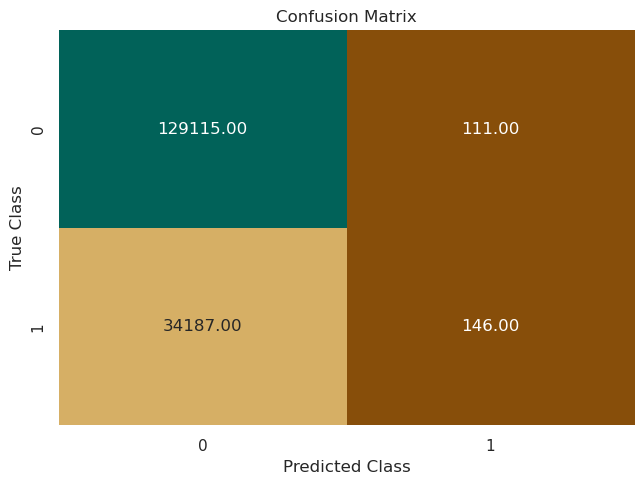

In [44]:
# 
plot_confusion_matrix(test_labels, target_predicted)
plt.show()

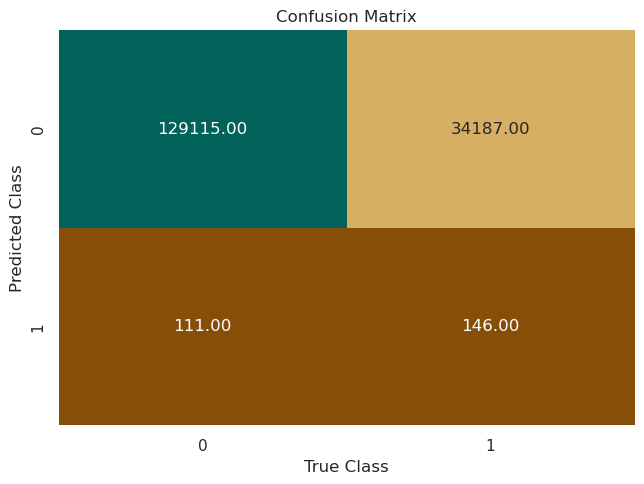

In [45]:
def plot_confusion_matrix_transpose(test_labels, target_predicted):
    matrix = confusion_matrix(target_predicted, test_labels)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("Predicted Class")
    plt.xlabel("True Class")
    plt.show()
    
plot_confusion_matrix_transpose(test_labels, target_predicted)
plt.show()

In [53]:
# ##Testing/Sanity Check of Precision, Recall, Accuracy, and F1-Score

# TP = 129115
# FP = 34187
# FN = 111
# TN = 146

# Precision = TP/(TP+FP)
# Recall = TP/(TP+FN)
# Support = TP+FP+FN+TN
# Accuracy = (TP+TN)/Support
# f1_score = (2*Precision*Recall)/(Precision+Recall)

# print("Precision: ", Precision)
# print("Recall: ", Recall)
# print("Accuracy: ", Accuracy)
# print("Support: ", Support)
# print("f1_score: ", f1_score) 

Precision:  0.790651676035811
Recall:  0.9991410397288472
Accuracy:  0.7903019705427399
Support:  163559
f1_score:  0.8827531039763716


### ROC Graph

Sensitivity or TPR:  0.4252468470567676 %
Specificity or TNR:  99.91410397288472 %
Precision:  56.809338521400775 %
Negative Predictive Value:  79.0651676035811 %
False Positive Rate:  0.0858960271152864 %
False Negative Rate:  99.57475315294323 %
False Discovery Rate:  43.190661478599225 %
Accuracy:  79.03019705427398 %
f1_score:  0.008441746169413126
Validation AUC 0.5016967540997074
Figure(640x480)


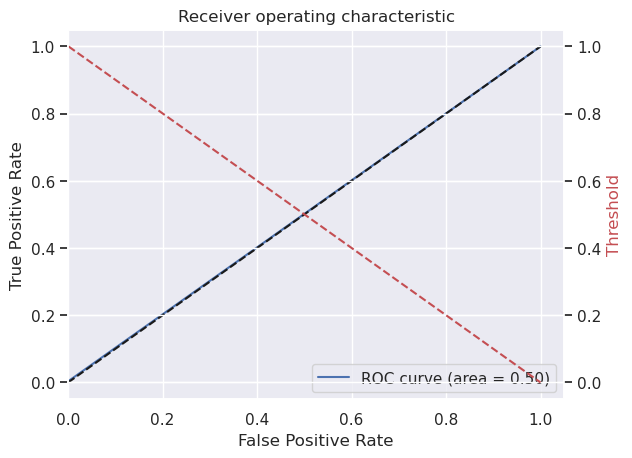

<Figure size 640x480 with 0 Axes>

In [55]:
#Plot ROC graph 
plot_roc(test_labels, target_predicted)

### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [56]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker


## BOOKMARK 3 -- Write 'test_labels' and 'target_predicted' DataFrames as CSVs to 'test_labels_csv_filepath' and 'target_predicted_csv_filepath', respectively

In [57]:
test_labels_csv_filepath = f"{base_path}test_labels_df.csv"
target_predicted_csv_filepath = f"{base_path}target_predicted_df.csv"
print(test_labels_csv_filepath)
print(target_predicted_csv_filepath)

/home/ec2-user/SageMaker/project/data/FlightDelays/test_labels_df.csv
/home/ec2-user/SageMaker/project/data/FlightDelays/target_predicted_df.csv


In [58]:
start = time.time()

test_labels.to_csv(test_labels_csv_filepath, index=False)
target_predicted.to_csv(target_predicted_csv_filepath, index=False)

print(f'Run time: {round((time.time() - start)/60,2)} minutes')

Run time: 0.0 minutes


## Load Pandas DataFrames from 'test_labels_csv_filepath' and 'target_predicted_csv_filepath' for completing Step 4

In [ ]:
test_labels_csv_filepath = f"{base_path}test_labels_df.csv"
target_predicted_csv_filepath = f"{base_path}target_predicted_df.csv"
print(test_labels_csv_filepath)
print(target_predicted_csv_filepath)

data_test_labels_all = pd.read_csv(test_labels_csv_filepath)
data_target_predicted_all = pd.read_csv(target_predicted_csv_filepath)
data_test_and_target_all = pd.concat([data_test_labels_all, data_target_predicted_all], axis=1)
print('data_test_and_target_all.shape: ', data_test_and_target_all.shape)

data_test_and_target_16k = data_test_and_target_all[:16000]
print('data_test_and_target_16k.shape: ', data_test_and_target_16k.shape)
##data_test_target = data_test_and_target_16k
data_test_target = data_test_and_target_all

In [ ]:
##Check which Columns are showing as having a string/object data type
data_test_target_dtypes_series = data_test_target.dtypes
data_test_target_dtypes_list = data_test_target_dtypes_series.tolist()
print(type(data_test_target_dtypes_series))
print(type(data_test_target_dtypes_list))
print(data_test_target_dtypes_list)

# Step 4: Feature engineering

Consider data changes that could possibly improve model performance?

### Key questions to consider:

1. How might the balance of the two main classes (*delay* and *no delay*) impact model performance?
2. Are features correlated?
3. At this stage, are there any feature-reduction techniques that might positively impact model performance? 
4. What additional data or datasets could be added?
5. After performing some feature engineering, how does the model performance compare to the first iteration?

### Additional Features to be added:

1. Holidays --- *Hypothesis: airplane delays could be higher during holidays compared to the rest of the days.* 
2. Weather --- *Hypothesis: perhaps bad weather like rain, heavy winds, or snow can lead to airplane delays.*

In [11]:
print(data_orig.shape)
display(data_orig.head(5))

(1635590, 21)


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2017        2      4           1          6  2017-04-01                DL   
1  2017        2      4           1          6  2017-04-01                DL   
2  2017        2      4           1          6  2017-04-01                DL   
3  2017        2      4           1          6  2017-04-01                DL   
4  2017        2      4           1          6  2017-04-01                DL   

  Origin OriginState Dest  ... CRSDepTime  Cancelled  Diverted  Distance  \
0    ATL          GA  DFW  ...       1920        0.0       0.0     731.0   
1    DFW          TX  ATL  ...       1717        0.0       0.0     731.0   
2    SFO          CA  ATL  ...       1405        0.0       0.0    2139.0   
3    SFO          CA  ATL  ...        600        0.0       0.0    2139.0   
4    ATL          GA  SFO  ...       1640        0.0       0.0    2139.0   

   DistanceGroup  ArrDelay  ArrDelayMinutes  is_delay  AirTime  DepHourofDay  
0              3     -25.0              0.0       0.0    106.0            19  
1              3     -16.0              0.0       0.0     97.0            17  
2              9      31.0             31.0       1.0    255.0            14  
3              9      15.0             15.0       1.0    257.0             6  
4              9      58.0             58.0       1.0    262.0            16  

[5 rows x 21 columns]

In [15]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
##data_orig['is_holiday'] = #  

print(type(holidays))
print(len(holidays))
print(data_orig.shape)
print(data_orig.columns)
#display(data_orig.head(5))
# data_orig['is_holiday'] = #  

data_orig_2 = data_orig.copy()
print(data_orig_2.dtypes)
data_orig_2['is_holiday'] = data_orig['FlightDate'].isin(holidays)

print()
print(data_orig_2.shape)
display(data_orig_2.head(5))

<class 'list'>
52
(1635590, 21)
Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')
Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

(1635590, 22)


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2017        2      4           1          6  2017-04-01                DL   
1  2017        2      4           1          6  2017-04-01                DL   
2  2017        2      4           1          6  2017-04-01                DL   
3  2017        2      4           1          6  2017-04-01                DL   
4  2017        2      4           1          6  2017-04-01                DL   

  Origin OriginState Dest  ... Cancelled  Diverted  Distance  DistanceGroup  \
0    ATL          GA  DFW  ...       0.0       0.0     731.0              3   
1    DFW          TX  ATL  ...       0.0       0.0     731.0              3   
2    SFO          CA  ATL  ...       0.0       0.0    2139.0              9   
3    SFO          CA  ATL  ...       0.0       0.0    2139.0              9   
4    ATL          GA  SFO  ...       0.0       0.0    2139.0              9   

   ArrDelay  ArrDelayMinutes  is_delay  AirTime  DepHourofDay  is_holiday  
0     -25.0              0.0       0.0    106.0            19       False  
1     -16.0              0.0       0.0     97.0            17       False  
2      31.0             31.0       1.0    255.0            14       False  
3      15.0             15.0       1.0    257.0             6       False  
4      58.0             58.0       1.0    262.0            16       False  

[5 rows x 22 columns]

### Weather data to add

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

In [16]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#!wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv to ../project/data/daily-summaries.csv


### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [17]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1004M   23G   5% /home/ec2-user/SageMaker


Import the weather data that was prepared for the airport codes in the dataset. Use the following stations and airports  for the analysis. Create a new column called *airport* that maps the weather station to the airport name.

In [18]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')

print(weather.shape)
display(weather.head())

station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

print(weather.shape)
display(weather.head())

(16434, 9)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0

(16434, 10)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport  
0     LAX  
1     LAX  
2     LAX  
3     LAX  
4     LAX

From the **DATE** column, create another column called *MONTH*.

In [19]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])

# weather.head()
print(weather.shape)
display(weather.head())

(16434, 11)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport MONTH  
0     LAX    01  
1     LAX    01  
2     LAX    01  
3     LAX    01  
4     LAX    01

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the **SNOW** and **SNWD** columns for missing values by using `fillna()`. To check the missing values for all the columns, use the `isna()` function.

In [20]:
weather.isna().sum()

STATION       0
DATE          0
AWND          0
PRCP          0
SNOW       4435
SNWD       4415
TAVG         62
TMAX         20
TMIN         20
airport       0
MONTH         0
dtype: int64

In [21]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

In [22]:
###Print the index of the rows that have missing values for *TAVG*, *TMAX*, *TMIN*.

# idx = np.array([i for i in range(len(weather))])
# TAVG_idx = idx[weather.TAVG.isna()] 
# TMAX_idx = #  
# TMIN_idx = #  
# TAVG_idx

idx = np.array([i for i in range(len(weather))])
print(idx[0:25,])
print(idx[0])
print(idx[-1])

TAVG_idx = idx[weather.TAVG.isna()] 
TMAX_idx = idx[weather.TMAX.isna()] 
TMIN_idx = idx[weather.TMIN.isna()] 

print(len(TAVG_idx))
print(TAVG_idx)

print(len(TMAX_idx))
print(TMAX_idx)

print(len(TMIN_idx))
print(TMIN_idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
0
16433
62
[ 3956  3957  3958  3959  3960  3961  3962  3963  3964  3965  3966  3967
  3968  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979
  3980  3981  3982  3983  3984  3985  4017  4018  4019  4020  4021  4022
  4023  4024  4025  4026  4027  4028  4029  4030  4031  4032  4033  4034
  4035  4036  4037  4038  4039  4040  4041  4042  4043  4044  4045  4046
  4047 13420]
20
[10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]
20
[10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]


### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing *TAVG*, *TMAX*, and *TMIN* values with the average value for a particular station or airport. Because consecutive rows of *TAVG_idx* are missing, replacing them with a previous value is not be possible, so instead, replace them with the mean. Use the `groupby` function to aggregate the variables with a mean value for each unique combination of 'MONTH' and 'STATION'.

In [24]:
weather_impute = weather.groupby(['MONTH','STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()
display(weather_impute)

MONTH      STATION        TAVG        TMAX        TMIN
0      01  USW00003017   -2.741935   74.000000  -69.858065
1      01  USW00003927   79.529032  143.767742   20.696774
2      01  USW00012960  110.535484  170.438710   52.425806
3      01  USW00013874   59.070968  114.600000    8.161290
4      01  USW00013881   48.929032  106.529032  -15.645161
..    ...          ...         ...         ...         ...
103    12  USW00013881   87.670968  138.870968   31.625806
104    12  USW00023174  147.922581  195.032258  102.038710
105    12  USW00023183  135.806452  198.206452   78.787097
106    12  USW00023234  115.025806  147.032258   80.361290
107    12  USW00094846   -2.735484   29.522581  -36.703226

[108 rows x 5 columns]

Merge the mean data with the weather data.

In [25]:
weather_2 = pd.merge(weather, weather_impute, how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

print(weather_2.shape)
display(weather_2.head())

(16434, 14)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   0.0   0.0  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   0.0   0.0  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   0.0   0.0  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   0.0   0.0  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   0.0   0.0  151.0  244.0   83.0   

  airport MONTH    TAVG_AVG    TMAX_AVG    TMIN_AVG  
0     LAX    01  148.619355  198.154839  103.477419  
1     LAX    01  148.619355  198.154839  103.477419  
2     LAX    01  148.619355  198.154839  103.477419  
3     LAX    01  148.619355  198.154839  103.477419  
4     LAX    01  148.619355  198.154839  103.477419

Check for missing values again.

In [26]:
weather = weather_2
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset.

In [27]:
print(weather.shape)
display(weather.head())

(16434, 14)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   0.0   0.0  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   0.0   0.0  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   0.0   0.0  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   0.0   0.0  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   0.0   0.0  151.0  244.0   83.0   

  airport MONTH    TAVG_AVG    TMAX_AVG    TMIN_AVG  
0     LAX    01  148.619355  198.154839  103.477419  
1     LAX    01  148.619355  198.154839  103.477419  
2     LAX    01  148.619355  198.154839  103.477419  
3     LAX    01  148.619355  198.154839  103.477419  
4     LAX    01  148.619355  198.154839  103.477419

In [28]:
weather_3 = weather.copy()
print(weather_3.shape)
display(weather_3.head())

(16434, 14)


STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   0.0   0.0  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   0.0   0.0  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   0.0   0.0  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   0.0   0.0  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   0.0   0.0  151.0  244.0   83.0   

  airport MONTH    TAVG_AVG    TMAX_AVG    TMIN_AVG  
0     LAX    01  148.619355  198.154839  103.477419  
1     LAX    01  148.619355  198.154839  103.477419  
2     LAX    01  148.619355  198.154839  103.477419  
3     LAX    01  148.619355  198.154839  103.477419  
4     LAX    01  148.619355  198.154839  103.477419

In [29]:
weather_3.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'], inplace=True)
print(weather_3.shape)
display(weather_3.head())

(16434, 6)


DATE  AWND  PRCP  SNOW   TAVG airport
0  2014-01-01    16     0   0.0  131.0     LAX
1  2014-01-02    22     0   0.0  159.0     LAX
2  2014-01-03    17     0   0.0  140.0     LAX
3  2014-01-04    18     0   0.0  136.0     LAX
4  2014-01-05    18     0   0.0  151.0     LAX

Add the origin and destination weather conditions to the dataset.

In [30]:
### Add origin weather conditions
data_orig_3 = pd.merge(data_orig_2, weather_3,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig_4 = pd.merge(data_orig_3, weather_3,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

print(data_orig_4.shape)
display(data_orig_4.head())

(1635590, 30)


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2017        2      4           1          6  2017-04-01                DL   
1  2017        2      4           1          6  2017-04-01                DL   
2  2017        2      4           1          6  2017-04-01                DL   
3  2017        2      4           1          6  2017-04-01                DL   
4  2017        2      4           1          6  2017-04-01                DL   

  Origin OriginState Dest  ... DepHourofDay  is_holiday  AWND_O  PRCP_O  \
0    ATL          GA  DFW  ...           19       False      43       0   
1    DFW          TX  ATL  ...           17       False      56       0   
2    SFO          CA  ATL  ...           14       False      42       0   
3    SFO          CA  ATL  ...            6       False      42       0   
4    ATL          GA  SFO  ...           16       False      43       0   

   SNOW_O  TAVG_O  AWND_D  PRCP_D  SNOW_D  TAVG_D  
0     0.0   173.0      56       0     0.0   209.0  
1     0.0   209.0      43       0     0.0   173.0  
2     0.0   159.0      43       0     0.0   173.0  
3     0.0   159.0      43       0     0.0   173.0  
4     0.0   173.0      42       0     0.0   159.0  

[5 rows x 30 columns]

**Note**: It's always a good practice to check for nulls or NAs after joins.

In [31]:
sum(data_orig_4.isna().any())

0

In [32]:
# data_orig.columns
print(data_orig_4.columns.tolist())

['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay', 'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'SNOW_D', 'TAVG_D']


Convert the categorical data into numerical data by using one-hot encoding.

In [33]:
data = data_orig_4[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
data_2 = data.copy()
for c in categorical_columns:
    data_2[c] = data[c].astype('category')

print(data_2.dtypes)

is_delay              float64
Year                 category
Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
Distance              float64
DepHourofDay            int64
is_holiday           category
AWND_O                  int64
PRCP_O                  int64
TAVG_O                float64
AWND_D                  int64
PRCP_D                  int64
TAVG_D                float64
SNOW_O                float64
SNOW_D                float64
dtype: object


In [34]:
data_dummies = pd.get_dummies(data_2[categorical_columns], drop_first=True)
data_3 = pd.concat([data_2, data_dummies], axis = 1)
data_3.drop(categorical_columns,axis=1, inplace=True)

print(data_3.shape)
print(data_3.dtypes.tolist())
display(data_3.head())

(1635590, 86)
[dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dt

is_delay  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0       0.0     731.0            19      43       0   173.0      56       0   
1       0.0     731.0            17      56       0   209.0      43       0   
2       1.0    2139.0            14      42       0   159.0      43       0   
3       1.0    2139.0             6      42       0   159.0      43       0   
4       1.0    2139.0            16      43       0   173.0      42       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   209.0     0.0  ...       False     False     False      True     False   
1   173.0     0.0  ...       False     False     False     False     False   
2   173.0     0.0  ...        True     False     False     False     False   
3   173.0     0.0  ...        True     False     False     False     False   
4   159.0     0.0  ...       False     False     False     False     False   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_True  
0     False     False     False     False            False  
1     False     False     False     False            False  
2     False     False     False     False            False  
3     False     False     False     False            False  
4     False     False     False      True            False  

[5 rows x 86 columns]

Check the new columns.

In [36]:
data_3.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the **is_delay** column to *target* again. Use the same code that you used previously.

In [37]:
data_3.rename(columns = {'is_delay':'target'}, inplace=True)
data_3_col_name_list = data_3.columns.tolist()
print(len(data_3_col_name_list))
print(data_3_col_name_list)

86
['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',

## BOOKMARK 4 --- Write 'data_3' DataFrame out as CSV to 'step_4_df_filepath'

In [40]:
step_3_df_filepath = f"{base_path}step_3_df.csv"
print(step_3_df_filepath)

/home/ec2-user/SageMaker/project/data/FlightDelays/step_3_df.csv


In [56]:
start = time.time()

data_3.to_csv(step_3_df_filepath, index=False) 

print(f'Run time: {round((time.time() - start)/60,2)} minutes')

Run time: 0.69 minutes


## ** Load Pandas DataFrame from 'step_3_df_filepath'

In [3]:
step_3_df_filepath = f"{base_path}step_3_df.csv"
print(step_3_df_filepath)

data_step3_all = pd.read_csv(step_3_df_filepath)
print('data_step3_all.shape: ', data_step3_all.shape)
data_step3_first_16k = data_step3_all[:16000]
print('data_step3_first_16k.shape: ', data_step3_first_16k.shape)
data = data_step3_first_16k
###data = data_step3_all

/home/ec2-user/SageMaker/project/data/FlightDelays/step_3_df.csv
data_step3_all.shape:  (1635590, 86)
data_step3_first_16k.shape:  (16000, 86)


In [4]:
###Check which Columns are showing as having a string/object data type

def inspect_df(df):
    if isinstance(df, pd.DataFrame):
        df_dtypes_series = df.dtypes
        df_dtypes_list = df_dtypes_series.tolist()
        print("Is a Pandas DataFrame!")
        print('Shape =', df.shape)
        
        # Check if any column has 'object' (string) dtype
        has_string_columns = (df.dtypes == 'object').any()
        if has_string_columns:
            print("At least one column has a string data type.")
        else:
            print("No columns have a string data type.")
        
        print('All Column names: ')
        print(df.columns)
        print('Boolean Column names: ')
        bool_cols = df.select_dtypes(include='bool').columns
        print(bool_cols)
        print(df_dtypes_list)
        display(df.head(5))
    else:
        print('Not a Pandas DataFrame!')
        print('Data Structure is: ', type(df))

inspect_df(data)

Is a Pandas DataFrame!
Shape = (16000, 86)
No columns have a string data type.
All Column names: 
Index(['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMont

target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     731.0            19      43       0   173.0      56       0   
1     0.0     731.0            17      56       0   209.0      43       0   
2     1.0    2139.0            14      42       0   159.0      43       0   
3     1.0    2139.0             6      42       0   159.0      43       0   
4     1.0    2139.0            16      43       0   173.0      42       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   209.0     0.0  ...       False     False     False      True     False   
1   173.0     0.0  ...       False     False     False     False     False   
2   173.0     0.0  ...        True     False     False     False     False   
3   173.0     0.0  ...        True     False     False     False     False   
4   159.0     0.0  ...       False     False     False     False     False   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_True  
0     False     False     False     False            False  
1     False     False     False     False            False  
2     False     False     False     False            False  
3     False     False     False     False            False  
4     False     False     False      True            False  

[5 rows x 86 columns]

## 4-1 LinearLearner Re-run with New Data

## 4-1-1. Train-Validate-Test Split

In [5]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [6]:
##Capture Column names of 'data' DataFrame as a List
list_of_col_names = data.columns
print('list_of_col_names: ', list_of_col_names)

train, validate, test = split_data(data)
print(type(train))
print(type(validate))
print(type(test))

train_target_series = train['target']
validate_target_series = validate['target']
test_target_series = test['target']

print(train_target_series.value_counts())
print(validate_target_series.value_counts())
print(test_target_series.value_counts())

print()
print(train_target_series.value_counts()/train_target_series.count())
print(validate_target_series.value_counts()/validate_target_series.count())
print(test_target_series.value_counts()/test_target_series.count())

list_of_col_names:  Index(['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'D

## 4-1-2. Convert DataFrame of train, validate, and test sets to Arrays with Non-string/object data types

In [7]:
start = time.time()

##Function for converting Dataframe to Array with all items having a float datatype
def df_to_float_array(df):
    df_to_array = df.values
    df_to_list_of_lists = df_to_array.tolist()
    #print(type(df))
    #print(type(df_to_array))
    #print(type(df_to_list_of_lists))
    df_to_list_of_arrays_float = []
    for sublist in df_to_list_of_lists:
        new_sublist = []
        sublist_array = np.array(sublist)
        sublist_array_float = sublist_array.astype(np.float32)
        df_to_list_of_arrays_float.append(sublist_array_float)
    df_to_array_float = np.array(df_to_list_of_arrays_float)
    print("\ntype(df_to_array_float): ", type(df_to_array_float))
    print("shape of df_to_array_float = ", df_to_array_float.shape)
    print("Data types of elements in df_to_array_float: ", df_to_array_float.dtype)
    #print()
    return df_to_array_float

##Function for converting DataFrame columns with String or Object datatype to a Boolean
def convert_object_cols_to_bool(df):
    #Select columns with 'object' (string) data type
    object_columns_df = df.select_dtypes(include=['object'])

    #Get a list of the column names
    object_column_names = object_columns_df.columns.tolist()

    print('\nList of column names with string or object data type:')
    print(object_column_names)

    #Convert cols with string/object type to boolean
    df[object_column_names] = df[object_column_names].astype(bool)

    print("\nDataFrame object dtypes after astype(bool):")
    print(df[object_column_names].dtypes)
    #print("\nDataFrame content after astype(bool):")
    #print(df[object_column_names].head(5))
    return df

train_no_objects = convert_object_cols_to_bool(train)
validate_no_objects = convert_object_cols_to_bool(validate)
test_no_objects = convert_object_cols_to_bool(test)

train_array_float = df_to_float_array(train_no_objects)
validate_array_float = df_to_float_array(validate_no_objects)
test_array_float = df_to_float_array(test_no_objects)

print(f'Run time: {round((time.time() - start)/60,2)} minutes')


List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

List of column names with string or object data type:
[]

DataFrame object dtypes after astype(bool):
Series([], dtype: object)

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (12800, 86)
Data types of elements in df_to_array_float:  float32

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (1600, 86)
Data types of elements in df_to_array_float:  float32

type(df_to_array_float):  <class 'numpy.ndarray'>
shape of df_to_array_float =  (1600, 86)
Data types of elements in df_to_array_float:  float32
Run time: 0.0 minutes


## 4-1-3. Imports for Building LinearLearner Model

In [8]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
# We no longer need TrainingInput for this workflow
from sagemaker import LinearLearner

from sklearn.model_selection import train_test_split
from sagemaker.analytics import TrainingJobAnalytics
import time
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup SageMaker Session and Role (Unchanged)
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/ll-records-2'

print(f"Using S3 bucket: {bucket}")
print(f"Using the following prefix: {prefix}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using S3 bucket: sagemaker-us-east-1-858332928583
Using the following prefix: sagemaker/ll-records-2


## 4-1-4. Create X and y for training, validation, and test sets

In [9]:
## Create X and y for training, validation, and test sets

X_train = train_array_float[:,1:]
y_train = train_array_float[:,0]
X_val = validate_array_float[:,1:]
y_val = validate_array_float[:,0]
X_test = test_array_float[:,1:]
y_test = test_array_float[:,0]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")
print(f"Test target shape: {y_test.shape}")

Training set shape: (12800, 85)
Validation set shape: (1600, 85)
Test set shape: (1600, 85)
Training target shape: (12800,)
Validation target shape: (1600,)
Test target shape: (1600,)


## 4-1-6. Create LinearLearner Estimator

In [10]:
start = time.time()

###Create the LinearLearner Estimator (Unchanged)
ll_estimator = LinearLearner(
    role=role,
    instance_count=1,
    #instance_type='ml.m5.large',
    instance_type='ml.m4.xlarge',
    predictor_type='binary_classifier',
    feature_dim=2,
    mini_batch_size=100,
    binary_classifier_model_selection_criteria = 'cross_entropy_loss',
    # Add this line to enable metric calculation
    #eval_metrics=['accuracy', 'binary_f1', 'precision', 'recall'],
    #eval_metrics=['validation:precision', 'recall'],
    eval_metrics=['validation:precision', 'validation:recall', 'validation:f1', 'validation:accuracy'],
    sagemaker_session=sagemaker_session
)


###Create RecordSet objects üí°
# Add this check before your ll_estimator.record_set() calls
print(f"Training data shapes:   Features={X_train.shape}, Labels={y_train.shape}")
print(f"Validation data shapes: Features={X_val.shape}, Labels={y_val.shape}")

# Expected output for the example code:
# Training data shapes:   Features=(800, 10), Labels=(800,)
# Validation data shapes: Features=(200, 10), Labels=(200,)

# This is the new, simplified way to handle data.
# The .record_set() method converts NumPy arrays to the required format and uploads them to a specified S3 location.
print("Formatting data and uploading to S3...")
train_records = ll_estimator.record_set(X_train, y_train, channel='train')
validation_records = ll_estimator.record_set(X_val, y_val, channel='validation')
print("Data upload complete.")


###Launch the training job with the correct fit() signature
# We now pass a list of RecordSet objects.
print("Starting model training...")
ll_estimator.fit([train_records, validation_records])
print("Training complete!")


###Get the Training Job Name
# This is the key piece of information you need for analytics
training_job_name = ll_estimator.latest_training_job.name
print(f"\nCompleted training job: {training_job_name}")



###Use SageMaker SDK/API to programmatically retrieve the Evaluation Metrics by describing the Training Job.
# Attach to an existing training job
training_job_name = training_job_name
sagemaker_session = sagemaker.Session()
job_description = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

# The metrics are in the 'FinalMetricDataList'
final_metrics = {m['MetricName']: m['Value'] for m in job_description['FinalMetricDataList']}

print(final_metrics)
# Example Output: {'test:mse': '0.12345', 'validation:mse': '0.12300'}

print(f'Run time: {round((time.time() - start)/60,2)} minutes') 

Training data shapes:   Features=(12800, 85), Labels=(12800,)
Validation data shapes: Features=(1600, 85), Labels=(1600,)
Formatting data and uploading to S3...


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-07-25-00-05-05-807


Data upload complete.
Starting model training...
2025-07-25 00:05:08 Starting - Starting the training job......
2025-07-25 00:05:42 Starting - Preparing the instances for training...
2025-07-25 00:06:15 Downloading - Downloading input data...
2025-07-25 00:06:45 Downloading - Downloading the training image......
2025-07-25 00:08:11 Training - Training image download completed. Training in progress....
2025-07-25 00:08:37 Uploading - Uploading generated training model...
2025-07-25 00:08:55 Completed - Training job completed
..Training seconds: 160
Billable seconds: 160
Training complete!

Completed training job: linear-learner-2025-07-25-00-05-05-807
{'validation:objective_loss': 0.4833454489707947, 'train:progress': 100.0, 'validation:binary_classification_accuracy': 0.778124988079071, 'validation:recall': 0.24570024013519287, 'train:throughput': 29785.224609375, 'validation:roc_auc_score': 0.7611373662948608, 'train:objective_loss': 0.47957396507263184, 'validation:objective_loss:fin

### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [11]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G  763M   23G   4% /home/ec2-user/SageMaker


In [12]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.8G     0  7.8G   0% /dev
tmpfs           7.9G     0  7.9G   0% /dev/shm
tmpfs           7.9G  700K  7.9G   1% /run
tmpfs           7.9G     0  7.9G   0% /sys/fs/cgroup
/dev/xvda1      135G   79G   57G  59% /
/dev/xvdf        25G  763M   23G   4% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1000
tmpfs           1.6G     0  1.6G   0% /run/user/0


## 4-1-7. Model Evaluation

In [13]:
import io
# bucket = ....
# prefix = ...
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [14]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

## 4-1-8. Convert Arrays for Training, Validation, and Test to DataFrames for use within the 'plot_confusion_matrix', and 'plot_roc' UDFs

In [15]:
import time
import os
start = time.time()

##Convert Numpy arrays for Training, Validation, and Test to DataFrames
def convert_array_to_df(array, list_of_col_names):
    print('Datatype of input to function: ', type(array))
    df = pd.DataFrame(array, columns=list_of_col_names)
    print('Datatype of output of funciton: ', type(df))
    print()
    return df

list_of_cv_array_names = [
    'train',
    'validation',
    'test'
]
list_of_cv_arrays = [
    train_array_float,
    validate_array_float,
    test_array_float
]
list_of_cv_dfs = []
cv_zip = zip(list_of_cv_array_names, list_of_cv_arrays)
dict_of_cv_dfs = {}

for index, zip_tuple in enumerate(cv_zip):
    print(index)
    df = convert_array_to_df(zip_tuple[1], list_of_col_names)
    dict_of_cv_dfs[zip_tuple[0]] = df

print('type(dict_of_cv_dfs): ', type(dict_of_cv_dfs))
print('len(dict_of_cv_dfs): ', len(dict_of_cv_dfs))
print("dict_of_cv_dfs.keys(): ", dict_of_cv_dfs.keys())
print("type(dict_of_cv_dfs['test']): ", type(dict_of_cv_dfs['test']))
print("dict_of_cv_dfs['test'].shape ", dict_of_cv_dfs['test'].shape)
df_test = dict_of_cv_dfs['test']
df_test_col_names = df_test.columns.tolist()
print("df_test_col_names: ", df_test_col_names)

0
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

1
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

2
Datatype of input to function:  <class 'numpy.ndarray'>
Datatype of output of funciton:  <class 'pandas.core.frame.DataFrame'>

type(dict_of_cv_dfs):  <class 'dict'>
len(dict_of_cv_dfs):  3
dict_of_cv_dfs.keys():  dict_keys(['train', 'validation', 'test'])
type(dict_of_cv_dfs['test']):  <class 'pandas.core.frame.DataFrame'>
dict_of_cv_dfs['test'].shape  (1600, 86)
df_test_col_names:  ['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', '

In [16]:
start = time.time()

test_labels, target_predicted = batch_linear_predict(dict_of_cv_dfs['test'], ll_estimator)

print(f'Run time: {round((time.time() - start)/60,2)} minutes') ##Run time for 16000 rows and 94 is 8.07 minutes 

##Run time for 16000 rows and 86 columns = 
##Run time for 1.6Million rows and 86 columns

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2025-07-25-00-09-23-937
INFO:sagemaker:Creating transform job with name: linear-learner-2025-07-25-00-09-24-523


..........................................
...Run time: 7.57 minutes


### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [17]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G  763M   23G   4% /home/ec2-user/SageMaker


In [18]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.8G     0  7.8G   0% /dev
tmpfs           7.9G     0  7.9G   0% /dev/shm
tmpfs           7.9G  700K  7.9G   1% /run
tmpfs           7.9G     0  7.9G   0% /sys/fs/cgroup
/dev/xvda1      135G   79G   57G  59% /
/dev/xvdf        25G  763M   23G   4% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1000
tmpfs           1.6G     0  1.6G   0% /run/user/0


## 4-1-9. Plot Confusion Matrix and ROC graph

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from the batch job:

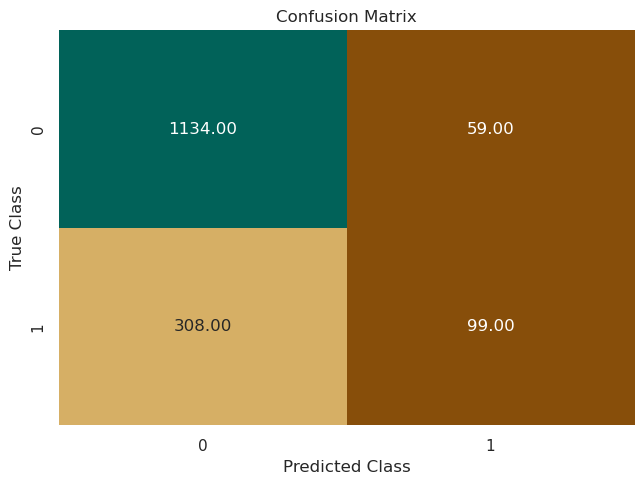

In [23]:
# 
plot_confusion_matrix(test_labels, target_predicted)
plt.show()

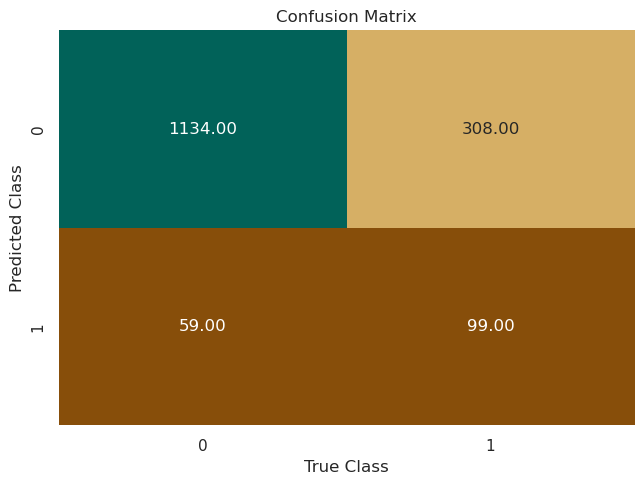

In [24]:
plot_confusion_matrix_transpose(test_labels, target_predicted)
plt.show()

To print statistics and plot a receiver operating characteristic (ROC) curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

### ROC Graph

Sensitivity or TPR:  24.324324324324326 %
Specificity or TNR:  95.0544844928751 %
Precision:  62.65822784810127 %
Negative Predictive Value:  78.64077669902912 %
False Positive Rate:  4.945515507124895 %
False Negative Rate:  75.67567567567568 %
False Discovery Rate:  37.34177215189873 %
Accuracy:  77.0625 %
f1_score:  0.3504424778761063
Validation AUC 0.5968940440859971
Figure(640x480)


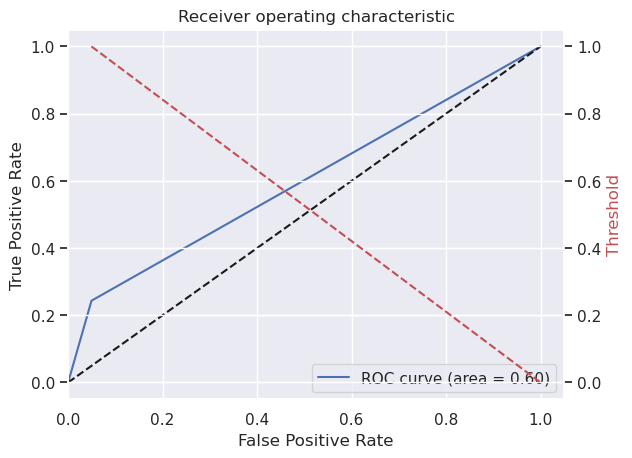

<Figure size 640x480 with 0 Axes>

In [25]:
#Plot the ROC graph
plot_roc(test_labels, target_predicted)

### CHECK volulme storage space (utilization and availability) within SageMaker notebook instance

In [56]:
! df -h /dev/xvdf

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvdf        25G 1002M   23G   5% /home/ec2-user/SageMaker


## 4-2 XGBoost Model

The linear model shows only a little improvement in performance. Try the tree-based ensemble model, *XGBoost*, to see if performance can be futher improved.

## 4-2-1 Upload Data to S3

### Convert Booleans of DataFrame to Floats

In [102]:
bool_cols = data.select_dtypes(include='bool').columns

data_2 = data.copy()
for col in bool_cols:
    data_2[col] = data_2[col].astype(float)

print(data_2.dtypes.tolist())

[dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), d

#### Train-Validate-Test Split

In [103]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [104]:
train, validate, test = split_data(data_2)
print(type(train))
print('train.shape: ', train.shape)
print(type(validate))
print('validate.shape: ', validate.shape)
print(type(test))
print('test.shape: ', test.shape)

<class 'pandas.core.frame.DataFrame'>
train.shape:  (12800, 86)
<class 'pandas.core.frame.DataFrame'>
validate.shape:  (1600, 86)
<class 'pandas.core.frame.DataFrame'>
test.shape:  (1600, 86)


#### Upload CSVs of Training set and Validation set to S3 bucket filepaths for use within XGBoost model

In [105]:
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os

import time

## Set up SageMaker Session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'xgboost-binary-classification-example'

# SageMaker XGBoost expects the target variable to be the first column
# Convert to CSV format without header and index for SageMaker built-in algorithm
train_csv_path = 'train.csv'
validate_csv_path = 'validate.csv'
# test_csv_path = 'test.csv'

train.to_csv(train_csv_path, header=False, index=False)
validate.to_csv(validate_csv_path, header=False, index=False)
#test.to_csv(validate_csv_path, header=False, index=False)

train_s3_path = sagemaker_session.upload_data(path=train_csv_path, bucket=bucket, key_prefix=f"{prefix}/train")
validate_s3_path = sagemaker_session.upload_data(path=validate_csv_path, bucket=bucket, key_prefix=f"{prefix}/validate")
#test_s3_path = sagemaker_session.upload_data(path=test_csv_path, bucket=bucket, key_prefix=f"{prefix}/test")

print(f"\nTraining data uploaded to: {train_s3_path}")
print(f"Validate data uploaded to: {validate_s3_path}")
#print(f"Test data uploaded to: {test_s3_path}")


Training data uploaded to: s3://sagemaker-us-east-1-496057999101/xgboost-binary-classification-example/train/train.csv
Validate data uploaded to: s3://sagemaker-us-east-1-496057999101/xgboost-binary-classification-example/validate/validate.csv


## 4-2-2 Train an XGBoost model using SageMaker's built-in algorithm

In [106]:
start = time.time()

container = sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "latest")

xgb_estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    #instance_type='ml.m5.xlarge', # A small instance type is sufficient for a small dataset
    instance_type='ml.m4.xlarge',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'objective': 'binary:logistic', # For binary classification
        'num_round': 100,               # Number of boosting rounds
        'eval_metric': 'auc',           # Evaluation metric
        'eta': 0.2,                     # Learning rate
        'max_depth': 5                  # Maximum depth of a tree
    }
)

train_input = TrainingInput(train_s3_path, content_type='csv')
validation_input = TrainingInput(validate_s3_path, content_type='csv')
#validation_input = TrainingInput(test_s3_path, content_type='csv') # Use test set as validation

print("\nStarting XGBoost training job...")
xgb_estimator.fit({'train': train_input, 'validation': validation_input})
print("Training complete.")

print(f'Run time: {round((time.time() - start)/60,2)} minutes')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: xgboost-2025-07-24-22-48-50-240



Starting XGBoost training job...
2025-07-24 22:48:52 Starting - Starting the training job...
2025-07-24 22:49:17 Starting - Preparing the instances for training...
2025-07-24 22:49:50 Downloading - Downloading input data...
2025-07-24 22:50:20 Downloading - Downloading the training image......
2025-07-24 22:51:21 Training - Training image download completed. Training in progress....
2025-07-24 22:51:55 Uploading - Uploading generated training model
2025-07-24 22:51:55 Completed - Training job completed
..Training seconds: 125
Billable seconds: 125
Training complete.
Run time: 3.28 minutes


## 4-2-3 Deploy the model to a SageMaker endpoint

In [107]:
## Deploy the model to a SageMaker endpoint
start = time.time()

print("\nDeploying model to endpoint...")
predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    #instance_type='ml.m5.xlarge', # Same instance type for deployment
    instance_type='ml.m4.xlarge',
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer()
)
print(f"Model deployed to endpoint: {predictor.endpoint_name}")

print(f'Run time: {round((time.time() - start)/60,2)} minutes')

INFO:sagemaker:Creating model with name: xgboost-2025-07-24-22-52-07-024



Deploying model to endpoint...


INFO:sagemaker:Creating endpoint-config with name xgboost-2025-07-24-22-52-07-024
INFO:sagemaker:Creating endpoint with name xgboost-2025-07-24-22-52-07-024


-------!Model deployed to endpoint: xgboost-2025-07-24-22-52-07-024
Run time: 4.03 minutes


## 4-2-4 Make Predictions with the Deployed Model

In [108]:
start = time.time()

# 6. Make predictions with the deployed model
# Prepare a small sample from the test set for prediction
X_val = validate.drop('target', axis=1)
y_val = validate['target']

### SAMPLE PREDICTIONS
# SageMaker expects CSV input for built-in algorithms
# We will send a few rows for demonstration
sample_for_prediction = X_val.head(5).values.tolist()

print(f"\nMaking predictions on sample data:")
print(f"Sample input features:\n{sample_for_prediction}")

predictions = predictor.predict(sample_for_prediction)
print(f"Raw predictions from endpoint (probabilities):\n{predictions}")

###Check structure and datatype of predictions
def item_types_of_list(list_input, num_of_items):
    if isinstance(list_input, list):
        print('Function input is a list!')
        list_of_types = []
        for items in list_input:
           list_of_types.append(type(items))
        print('list length: ', len(list_input))
        print('number of list items to investigate: ', num_of_items)
        print(list_of_types[0:num_of_items])
        print()
    else:
        print('Function input is NOT a list!')
    return list_of_types

item_types_of_list(predictions, 3)
item_types_of_list(predictions[0], 3)

predictions_fixed = [float(s) for s in predictions[0]]
item_types_of_list(predictions_fixed, 3)


# Convert probabilities to binary class labels (0 or 1)
##predicted_classes = [1 if p > 0.5 else 0 for p in predictions]
predicted_classes = [1 if p > 0.5 else 0 for p in predictions_fixed]
print(f"Predicted classes (threshold 0.5):\n{predicted_classes}")
print(f"Actual classes for sample:\n{y_val.head(5).tolist()}")


### FULL PREDICTIONS
# Evaluate the model on the full test set (optional, but good practice)
# For larger datasets, batch transform is recommended
# For this small dataset, we can send it piece by piece or if small enough, all at once
all_predictions = predictor.predict(X_val.values.tolist())

item_types_of_list(all_predictions[0], 3)
all_predictions_fixed = [float(s) for s in all_predictions[0]]
item_types_of_list(all_predictions_fixed, 3)

##all_predicted_classes = [1 if p > 0.5 else 0 for p in all_predictions]
all_predicted_classes = [1 if p > 0.5 else 0 for p in all_predictions_fixed]


### Evaluation Metrics
print(f"\nAccuracy on test set: {accuracy_score(y_val, all_predicted_classes):.4f}")
print("\nClassification Report on test set:")
print(classification_report(y_val, all_predicted_classes))

print(f'Run time: {round((time.time() - start)/60,2)} minutes')



Making predictions on sample data:
Sample input features:
[[1587.0, 14.0, 40.0, 20.0, 137.0, 48.0, 0.0, 288.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1464.0, 13.0, 42.0, 51.0, 197.0, 46.0, 13.0, 142.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [602.0, 20.0, 48.0, 0.0, 288.0, 57.0, 0.0, 142.0, 0.0, 0.0, 0.0

In [109]:
test_labels = y_val
target_predicted = all_predicted_classes
target_predicted_series = pd.Series(target_predicted)

print(type(test_labels))
print(type(target_predicted_series))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Plot a confusion matrix for your `target_predicted` and `test_labels`.

## 4-2-5 Plot Confusion Matrix and ROC graph

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from your batch job:

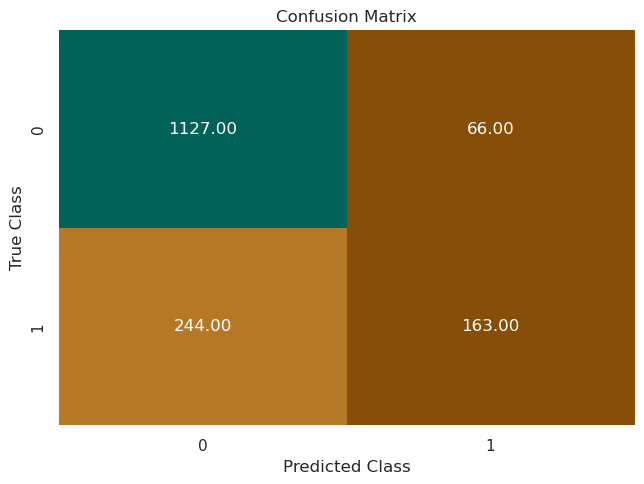

In [114]:
# Plot Confustion Matrix
plot_confusion_matrix(test_labels, target_predicted_series)
plt.show()

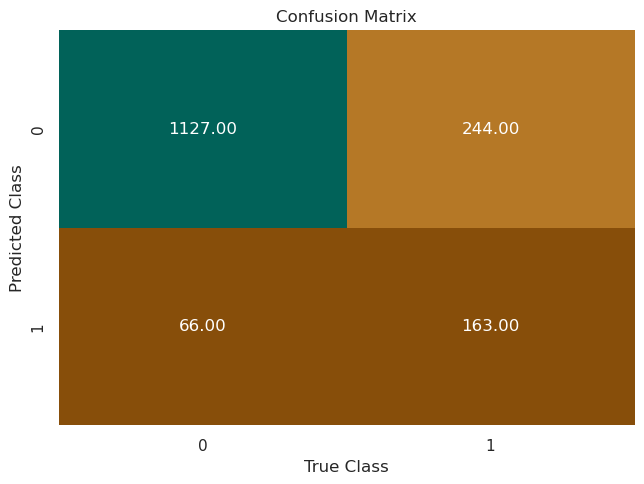

In [116]:
plot_confusion_matrix_transpose(test_labels, target_predicted_series)
plt.show()

### ROC Graph

Sensitivity or TPR:  40.04914004914005 %
Specificity or TNR:  94.46772841575859 %
Precision:  71.17903930131004 %
Negative Predictive Value:  82.20277169948942 %
False Positive Rate:  5.532271584241409 %
False Negative Rate:  59.95085995085995 %
False Discovery Rate:  28.82096069868996 %
Accuracy:  80.625 %
f1_score:  0.5125786163522013
Validation AUC 0.6725843423244932
Figure(640x480)


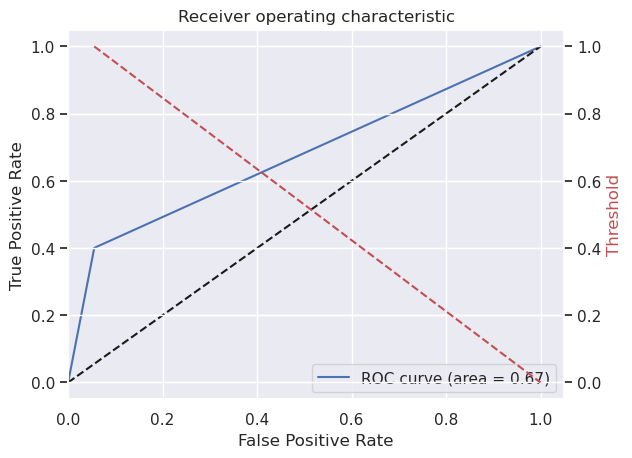

<Figure size 640x480 with 0 Axes>

In [118]:
# 
plot_roc(test_labels, target_predicted_series)

### Try different thresholds

### Hyperparameter optimization (HPO)

In [31]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

container = sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "latest")
sess = sagemaker_session
instance_type='ml.m4.xlarge'

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have a limit set for these instances
                                    instance_type=instance_type, 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000, scaling_type='Linear'),
                         'eta': ContinuousParameter(0.1, 0.5, scaling_type='Linear'),
                         'min_child_weight': ContinuousParameter(3, 10, scaling_type='Linear'),
                         'subsample': ContinuousParameter(0.5, 1),
                         'num_round': IntegerParameter(10,150)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget and available time.
                            max_parallel_jobs=1)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [32]:
tuner.fit(inputs=data_channels)
tuner.wait()

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Traceback (most recent call last) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ in <module>:1                                                                                    ‚îÇ
‚îÇ                                                                                                  ‚îÇ
‚îÇ ‚ù± 1 tuner.fit(inputs=data_channels)                                                              ‚îÇ
‚îÇ   2 tuner.wait()                                                                                 ‚îÇ
‚îÇ   3                                                                                              ‚îÇ
‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ
NameError: name 'data_channels' is not defined

<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It might take 25-30 minutes.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

Check that the job completed successfully.

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

The hyperparameter tuning job will have a model that worked the best. You can get the information about that model from the tuning job.

In [ ]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
print(f'tuning job name:{tuning_job_name}')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job = tuning_job_result['BestTrainingJob']
best_training_job_name = best_training_job['TrainingJobName']
print(f"best training job: {best_training_job_name}")

best_estimator = tuner.best_estimator()

tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuner_df.head()

Use the estimator `best_estimator` and train it by using the data. 

**Tip:** See the previous XGBoost estimator fit function.

Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_estimator.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])
test_labels = test.iloc[:,0]

Get the predicted target and test labels.

In [ ]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

Plot a confusion matrix for your `target_predicted` and `test_labels`.

In [ ]:
#plot_confusion_matrix_transpose(test_labels, target_predicted)
#plt.show()

Plot the ROC chart:

In [ ]:
#plot_roc(test_labels, target_predicted_series)

## Model Performance Against Business Goal:

While the final model exhibited improved precision, recall, and area under the curve (AUC), it may not entirely meet the business objective of accurately predicting flight delays for customer notifications. There is still room to enhance recall to ensure that more true positives are captured (i.e., actual delays).

### Challenges Faced:

Complexity of Datasets: Handling large datasets with several features presented challenges in maintaining data integrity. Integrating weather data with flight performance was initially cumbersome, requiring careful merging and imputation for misshaped data.
Hyperparameter Tuning Pitfalls: Designing the tuning process for hyperparameters can be tricky as optimizing one aspect can inadvertently detract from another, requiring careful monitoring and adjustment.
Unanswered Questions:

The impact of unobserved variables, such as air traffic congestion or airport operational efficiency, on delays remains critical. Assessing how these factors can be quantified and incorporated into predictive modeling is of interest.
Understanding the trade-offs between false positives and false negatives in the context of customer satisfaction: a false positive (indicating a delay when there isn't one) could frustrate customers.
Three Key Learnings about Machine Learning:

Feature Engineering is Crucial: The role of thoughtful feature selection and engineering cannot be understated; they directly influence model performance.
Model Complexity vs. Interpretability: More complex models (like ensemble models) may offer greater performance but at the cost of interpretability.
Data Quality Over Quantity: Quality, clean data, with well-constructed features, often leads to better outcomes than simply relying on larger datasets without careful curation.
This project presents valuable lessons applicable to future endeavors in flight prediction systems or similar data-driven domains, enhancing customer experiences through proactive communication strategies.